Link to colab: https://colab.research.google.com/drive/1mbCoJRHUsmRJSflmugHodTKMqJfwKy8_?usp=sharing

In [ ]:
# !wget -O boards_ccrl_1of4.tar 'https://drive.google.com/u/0/uc?id=1wjQfjg8Wee-jVY0gb5L_XXpxCFnc3l_P&confirm=t'
# !tar -xf boards_ccrl_1of4.tar

!wget -O boards_ccrl_2of4.tar 'https://drive.google.com/u/0/uc?id=1WPJgujT75pQFi-WrI2sZIemBBuPJjZSd&confirm=t'
!tar -xf boards_ccrl_2of4.tar

# !wget -O boards_ccrl_3of4.tar 'https://drive.google.com/u/0/uc?id=1CMDXA7OHmK-ZzLkhXV372bV5keVutFeZ&confirm=t'
# !tar -xf boards_ccrl_3of4.tar

# !wget -O boards_ccrl_4of4.tar 'https://drive.google.com/u/0/uc?id=1-6VPabZRFnvz-aHJ43TAMuufSIuh4-d4&confirm=t'
# !tar -xf boards_ccrl_4of4.tar

!mv boards_ccrl data
!pip install chess

--2023-05-17 05:37:01--  https://drive.google.com/u/0/uc?id=1WPJgujT75pQFi-WrI2sZIemBBuPJjZSd&confirm=t
Resolving drive.google.com (drive.google.com)... 64.233.188.138, 64.233.188.113, 64.233.188.139, ...
Connecting to drive.google.com (drive.google.com)|64.233.188.138|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://drive.google.com/uc?id=1WPJgujT75pQFi-WrI2sZIemBBuPJjZSd&confirm=t [following]
--2023-05-17 05:37:01--  https://drive.google.com/uc?id=1WPJgujT75pQFi-WrI2sZIemBBuPJjZSd&confirm=t
Reusing existing connection to drive.google.com:443.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-10-bo-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/ss31j18ihg85pgjveef5gr2koje05leo/1684301775000/18334911380517025247/*/1WPJgujT75pQFi-WrI2sZIemBBuPJjZSd?uuid=9a00bc07-ebc7-482e-b1b1-d7d31cef914f [following]
--2023-05-17 05:37:02--  https://doc-10-bo-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7

In [ ]:
#@title Setup - Get ChessGNN repo (wait until session restarts)
def get_repo_and_install():
    import subprocess

    assert subprocess.getstatusoutput(f"git clone --depth=1 https://github.com/marcinz99/ChessGNN.git")[0] == 0
    assert subprocess.getstatusoutput(f"pip install -e ChessGNN/")[0] == 0
    exit()

get_repo_and_install()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd ChessGNN
!git remote set-branches --add origin task-6_paste_code_from_notebooks
!git fetch origin task-6_paste_code_from_notebooks:task-6_paste_code_from_notebooks
!git checkout task-6_paste_code_from_notebooks
!git branch --set-upstream-to=origin/task-6_paste_code_from_notebooks task-6_paste_code_from_notebooks
!git pull
%cd ..

/content/ChessGNN
remote: Enumerating objects: 75, done.
remote: Counting objects: 100% (75/75), done.
remote: Compressing objects: 100% (47/47), done.
remote: Total 67 (delta 35), reused 51 (delta 19), pack-reused 0
Unpacking objects: 100% (67/67), 14.04 KiB | 898.00 KiB/s, done.
From https://github.com/marcinz99/ChessGNN
 * [new branch]      task-6_paste_code_from_notebooks -> task-6_paste_code_from_notebooks
 * [new branch]      task-6_paste_code_from_notebooks -> origin/task-6_paste_code_from_notebooks
Switched to branch 'task-6_paste_code_from_notebooks'
Branch 'task-6_paste_code_from_notebooks' set up to track remote branch 'task-6_paste_code_from_notebooks' from 'origin'.
Already up to date.
/content


In [ ]:
!cd ChessGNN; git pull

Already up to date.


In [ ]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import subprocess
import chess
import os
import gc
import itertools
from tensorflow.data import Dataset
from chessgnn.graphchess.data_ingestion import get_dataset, select_targets, get_squarewise_features, prepare_features
from chessgnn.graphchess.architecture import input_block, full_block, regular_mlp_head, softmax_mlp_head
from chessgnn.graphchess.helpers import load_model

pd.set_option('display.max_columns', None)
plt.rcParams['figure.dpi'] = 72
DRIVE_PATH = "/content/drive/MyDrive/Praca magisterska/Colabs 4 - Final work/Models/"

def run_cmd(cmd):
    subprocess.check_output([cmd], shell=True)

[0.98       0.974375   0.95750004 0.929375   0.89       0.839375
 0.77750003 0.70437497 0.62       0.52437496 0.41750002 0.29937494
 0.16999996 0.02937496 0.         0.        ]


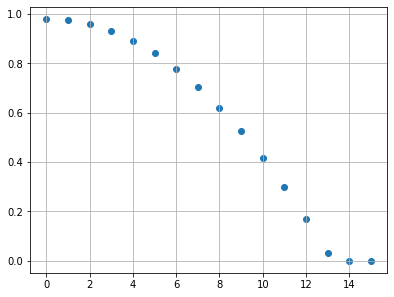

In [ ]:
@tf.function
def filter_by_ply_counts(x):
    return tf.maximum(0.0, 0.98 - tf.pow(0.075 * tf.cast(x, dtype=tf.float32), 2))


plt.scatter(np.arange(16), filter_by_ply_counts(np.arange(16)))
plt.grid()
print(filter_by_ply_counts(np.arange(16)).numpy())

In [ ]:
all_stats = [
    'loss', 'checked_in_1_loss', 'checked_in_3_loss', 'checking_in_1_loss', 'checking_in_3_loss',
    'final_result_loss', 'legal_captures_loss', 'legal_moves_loss', 'next_move_loss',
    'next_pieces_captured_loss', 'next_pieces_moved_loss', 'plies_till_end_loss',
    'checked_in_1_precision', 'checked_in_1_recall', 'checked_in_3_precision', 'checked_in_3_recall',
    'checking_in_1_precision', 'checking_in_1_recall', 'checking_in_3_precision', 'checking_in_3_recall',
    'final_result_accuracy', 'legal_captures_mae', 'legal_moves_mae',
    'next_move_accuracy', 'next_move_top_2_accuracy', 'next_move_top_3_accuracy', 'next_move_top_5_accuracy',
    'next_move_top_10_accuracy', 'next_pieces_captured_mae', 'next_pieces_moved_mae', 'plies_till_end_mae'
 ]


def train_and_save(model, set_num, targets, n_sample, logfile=None, drop_duplicates=0):
    data_path = f'data/boards_{(set_num - 1) * 2500 :0>7}.parquet'
    print(f"Epoch {set_num} (reading games from: {data_path})\n")

    if drop_duplicates > 0:
        ds = get_dataset(data_file_path=data_path, shuffle=True, drop_duplicates=drop_duplicates)
    else:
        ds = get_dataset(data_file_path=data_path, shuffle=True)
        ds = ds.filter(lambda x: filter_by_ply_counts(x['ply_counter']) < tf.random.uniform([]))  # Filter out openings
    ds = ds.map(prepare_features)
    ds = ds.batch(1)

    history = model.fit((
        ds
        .map(select_targets(
            input_list=['pos_feats', 'glob_feats', 'coo_graph', 'legal_moves'],
            target_list=targets))
        .take(n_sample)
        .prefetch(100)
    ))
    gc.collect()

    model.save(f"graphchess_{set_num}.h5")
    run_cmd(f'cp graphchess_{set_num}.h5 "{DRIVE_PATH}"')

    if logfile:
        logs = pd.read_parquet(DRIVE_PATH + logfile)

        new_entry = pd.DataFrame(history.history, columns=all_stats)
        new_entry['episode'] = set_num

        logs = pd.concat([logs, new_entry], axis='rows').sort_values('episode').reset_index(drop=True)
        logs.to_parquet(logfile)
        run_cmd(f'cp {logfile} "{DRIVE_PATH}"')

## Load model

In [ ]:
model_ver = 94
run_cmd(f'cp "{DRIVE_PATH}graphchess_{model_ver}.h5" .')
model = load_model(f"graphchess_{model_ver}.h5")

## Define new model

In [ ]:
from chessgnn.gnn.structures import leaky_relu
tf.keras.backend.clear_session()

pos_feats_input = tf.keras.Input(shape=(None, 12), dtype=tf.float32, batch_size=1, name='pos_feats_input')
glob_feats_input = tf.keras.Input(shape=(8,), dtype=tf.float32, batch_size=1, name='glob_feats_input')
coo_graph_input = tf.keras.Input(shape=(None, 2), dtype=tf.int32, batch_size=1, name='coo_graph_input')
legal_moves_input = tf.keras.Input(shape=(None,), dtype=tf.float32, batch_size=1, name='legal_moves_input')

receivers = coo_graph_input[..., 0]
senders = coo_graph_input[..., 1]

v, e, u = input_block(pos_feats_input, glob_feats_input, legal_moves_input, receivers, senders)

for i in range(10):
    v, e, u = full_block(v, e, u, receivers, senders, f"BLOCK_{i + 1}")

v_next_pieces_moved = regular_mlp_head(v, units=[72, 32, 1], name='next_pieces_moved', final_activation=leaky_relu())
v_next_pieces_captured = regular_mlp_head(v, units=[72, 32, 1], name='next_pieces_captured', final_activation=leaky_relu())

e_next_move = softmax_mlp_head(e, units=[72, 32, 1], name='next_move')
e_legal_moves = regular_mlp_head(e, units=[72, 32, 1], name='legal_moves', final_activation=leaky_relu())
e_legal_captures = regular_mlp_head(e, units=[72, 32, 1], name='legal_captures', final_activation=leaky_relu())

u_checked_in_1 = regular_mlp_head(u, units=[72, 32, 1], name='checked_in_1', final_activation=leaky_relu())
u_checked_in_3 = regular_mlp_head(u, units=[72, 32, 1], name='checked_in_3', final_activation=leaky_relu())
u_checking_in_1 = regular_mlp_head(u, units=[72, 32, 1], name='checking_in_1', final_activation=leaky_relu())
u_checking_in_3 = regular_mlp_head(u, units=[72, 32, 1], name='checking_in_3', final_activation=leaky_relu())
u_plies_till_end = regular_mlp_head(u, units=[72, 32, 1], name='plies_till_end', final_activation=leaky_relu())
u_final_result = softmax_mlp_head(u, units=[72, 32, 3], name='final_result')

model = tf.keras.Model(
    inputs={
        'pos_feats': pos_feats_input,
        'glob_feats': glob_feats_input,
        'coo_graph': coo_graph_input,
        'legal_moves': legal_moves_input,
    },
    outputs={
        'next_pieces_moved': v_next_pieces_moved,
        'next_pieces_captured': v_next_pieces_captured,
        'next_move': e_next_move,
        'legal_moves': e_legal_moves,
        'legal_captures': e_legal_captures,
        'checked_in_1': u_checked_in_1,
        'checked_in_3': u_checked_in_3,
        'checking_in_1': u_checking_in_1,
        'checking_in_3': u_checking_in_3,
        'plies_till_end': u_plies_till_end,
        'final_result': u_final_result,
    },
)
model.summary(line_length=180, positions=[0.5, 0.65, 0.725, 1.0])

Model: "model"
____________________________________________________________________________________________________________________________________________________________________________________
 Layer (type)                                                                             Output Shape               Param #      Connected to                                      
 pos_feats_input (InputLayer)                                                             [(1, None, 12)]            0            []                                                
                                                                                                                                                                                    
 coo_graph_input (InputLayer)                                                             [(1, None, 2)]             0            []                                                
                                                                                

In [ ]:
model.compile(
    loss={
        'next_pieces_moved': 'mse',
        'next_pieces_captured': 'mse',
        'next_move': 'categorical_crossentropy',
        'legal_moves': 'mse',
        'legal_captures': 'mse',
        'checked_in_1': 'mse',
        'checked_in_3': 'mse',
        'checking_in_1': 'mse',
        'checking_in_3': 'mse',
        'plies_till_end': 'mse',
        'final_result': 'categorical_crossentropy',
    },
    optimizer=tf.keras.optimizers.Nadam(learning_rate=2e-5, clipvalue=3.0),
    metrics={
        'next_pieces_moved': ['mae'],
        'next_pieces_captured': ['mae'],
        'next_move': [
            'accuracy',
            tf.keras.metrics.TopKCategoricalAccuracy(k=2, name='top_2_accuracy'),
            tf.keras.metrics.TopKCategoricalAccuracy(k=3, name='top_3_accuracy'),
            tf.keras.metrics.TopKCategoricalAccuracy(k=5, name='top_5_accuracy'),
            tf.keras.metrics.TopKCategoricalAccuracy(k=10, name='top_10_accuracy'),
        ],
        'legal_moves': ['mae'],
        'legal_captures': ['mae'],
        'checked_in_1': [tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')],
        'checked_in_3': [tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')],
        'checking_in_1': [tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')],
        'checking_in_3': [tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')],
        'plies_till_end': ['mae'],
        'final_result': ['accuracy'],
    },
)

In [ ]:
# def init_new_empty_logfile(name):
#     pd.DataFrame().to_parquet(name)
#     run_cmd(f'cp {name} "{DRIVE_PATH}"')

# init_new_empty_logfile('logs.parquet')

## Training

### 0-50k

In [ ]:
train_and_save(
    model=model, set_num=1,
    targets=[
        'next_pieces_moved', 'next_pieces_captured', 'next_move', 'legal_moves', 'legal_captures',
        'checked_in_1', 'checked_in_3', 'checking_in_1', 'checking_in_3', 'plies_till_end', 'final_result'],
    n_sample=20000, logfile='logs.parquet')

Epoch 1 (reading games from: data/boards_0000000.parquet)

20000/20000 [==============================] - 2024s 97ms/step - loss: 4.6203 - checked_in_1_loss: 0.0597 - checked_in_3_loss: 0.1166 - checking_in_1_loss: 0.0589 - checking_in_3_loss: 0.1159 - final_result_loss: 0.9257 - legal_captures_loss: 0.0045 - legal_moves_loss: 0.0095 - next_move_loss: 3.2169 - next_pieces_captured_loss: 0.0244 - next_pieces_moved_loss: 0.0653 - plies_till_end_loss: 0.0229 - checked_in_1_precision: 0.0000e+00 - checked_in_1_recall: 0.0000e+00 - checked_in_3_precision: 0.1190 - checked_in_3_recall: 0.0018 - checking_in_1_precision: 0.1667 - checking_in_1_recall: 0.0033 - checking_in_3_precision: 0.3056 - checking_in_3_recall: 0.0039 - final_result_accuracy: 0.5998 - legal_captures_mae: 0.0336 - legal_moves_mae: 0.0451 - next_move_accuracy: 0.1299 - next_move_top_2_accuracy: 0.2091 - next_move_top_3_accuracy: 0.2701 - next_move_top_5_accuracy: 0.3607 - next_move_top_10_accuracy: 0.5304 - next_pieces_captu

In [ ]:
train_and_save(
    model=model, set_num=2,
    targets=[
        'next_pieces_moved', 'next_pieces_captured', 'next_move', 'legal_moves', 'legal_captures',
        'checked_in_1', 'checked_in_3', 'checking_in_1', 'checking_in_3', 'plies_till_end', 'final_result'],
    n_sample=20000, logfile='logs.parquet')

Epoch 2 (reading games from: data/boards_0002500.parquet)

20000/20000 [==============================] - 1931s 96ms/step - loss: 4.3014 - checked_in_1_loss: 0.0587 - checked_in_3_loss: 0.1178 - checking_in_1_loss: 0.0606 - checking_in_3_loss: 0.1155 - final_result_loss: 0.8780 - legal_captures_loss: 4.5132e-04 - legal_moves_loss: 2.7364e-04 - next_move_loss: 2.9732 - next_pieces_captured_loss: 0.0220 - next_pieces_moved_loss: 0.0542 - plies_till_end_loss: 0.0207 - checked_in_1_precision: 0.0000e+00 - checked_in_1_recall: 0.0000e+00 - checked_in_3_precision: 0.2632 - checked_in_3_recall: 0.0017 - checking_in_1_precision: 0.0000e+00 - checking_in_1_recall: 0.0000e+00 - checking_in_3_precision: 0.4490 - checking_in_3_recall: 0.0075 - final_result_accuracy: 0.6330 - legal_captures_mae: 0.0101 - legal_moves_mae: 0.0087 - next_move_accuracy: 0.1697 - next_move_top_2_accuracy: 0.2659 - next_move_top_3_accuracy: 0.3336 - next_move_top_5_accuracy: 0.4320 - next_move_top_10_accuracy: 0.6130 - n

In [ ]:
train_and_save(
    model=model, set_num=3,
    targets=[
        'next_pieces_moved', 'next_pieces_captured', 'next_move', 'legal_moves', 'legal_captures',
        'checked_in_1', 'checked_in_3', 'checking_in_1', 'checking_in_3', 'plies_till_end', 'final_result'],
    n_sample=20000, logfile='logs.parquet')

Epoch 3 (reading games from: data/boards_0005000.parquet)

20000/20000 [==============================] - 1943s 97ms/step - loss: 4.2938 - checked_in_1_loss: 0.0583 - checked_in_3_loss: 0.1177 - checking_in_1_loss: 0.0575 - checking_in_3_loss: 0.1150 - final_result_loss: 0.9199 - legal_captures_loss: 2.2835e-04 - legal_moves_loss: 1.1050e-04 - next_move_loss: 2.9288 - next_pieces_captured_loss: 0.0224 - next_pieces_moved_loss: 0.0539 - plies_till_end_loss: 0.0201 - checked_in_1_precision: 0.0000e+00 - checked_in_1_recall: 0.0000e+00 - checked_in_3_precision: 0.4138 - checked_in_3_recall: 0.0040 - checking_in_1_precision: 0.0000e+00 - checking_in_1_recall: 0.0000e+00 - checking_in_3_precision: 0.3030 - checking_in_3_recall: 0.0034 - final_result_accuracy: 0.6003 - legal_captures_mae: 0.0065 - legal_moves_mae: 0.0045 - next_move_accuracy: 0.1824 - next_move_top_2_accuracy: 0.2829 - next_move_top_3_accuracy: 0.3530 - next_move_top_5_accuracy: 0.4521 - next_move_top_10_accuracy: 0.6335 - n

In [ ]:
train_and_save(
    model=model, set_num=4,
    targets=[
        'next_pieces_moved', 'next_pieces_captured', 'next_move', 'legal_moves', 'legal_captures',
        'checked_in_1', 'checked_in_3', 'checking_in_1', 'checking_in_3', 'plies_till_end', 'final_result'],
    n_sample=20000, logfile='logs.parquet')

Epoch 4 (reading games from: data/boards_0007500.parquet)

20000/20000 [==============================] - 1931s 96ms/step - loss: 4.2282 - checked_in_1_loss: 0.0592 - checked_in_3_loss: 0.1171 - checking_in_1_loss: 0.0567 - checking_in_3_loss: 0.1130 - final_result_loss: 0.9003 - legal_captures_loss: 1.4749e-04 - legal_moves_loss: 6.4524e-05 - next_move_loss: 2.8862 - next_pieces_captured_loss: 0.0216 - next_pieces_moved_loss: 0.0529 - plies_till_end_loss: 0.0208 - checked_in_1_precision: 0.0000e+00 - checked_in_1_recall: 0.0000e+00 - checked_in_3_precision: 0.4000 - checked_in_3_recall: 0.0027 - checking_in_1_precision: 0.0000e+00 - checking_in_1_recall: 0.0000e+00 - checking_in_3_precision: 0.4935 - checking_in_3_recall: 0.0130 - final_result_accuracy: 0.6162 - legal_captures_mae: 0.0047 - legal_moves_mae: 0.0029 - next_move_accuracy: 0.1891 - next_move_top_2_accuracy: 0.2964 - next_move_top_3_accuracy: 0.3641 - next_move_top_5_accuracy: 0.4659 - next_move_top_10_accuracy: 0.6535 - n

In [ ]:
train_and_save(
    model=model, set_num=5,
    targets=[
        'next_pieces_moved', 'next_pieces_captured', 'next_move', 'legal_moves', 'legal_captures',
        'checked_in_1', 'checked_in_3', 'checking_in_1', 'checking_in_3', 'plies_till_end', 'final_result'],
    n_sample=20000, logfile='logs.parquet')

Epoch 5 (reading games from: data/boards_0010000.parquet)

20000/20000 [==============================] - 1933s 97ms/step - loss: 4.2302 - checked_in_1_loss: 0.0548 - checked_in_3_loss: 0.1103 - checking_in_1_loss: 0.0556 - checking_in_3_loss: 0.1111 - final_result_loss: 0.9122 - legal_captures_loss: 1.0584e-04 - legal_moves_loss: 4.3940e-05 - next_move_loss: 2.8924 - next_pieces_captured_loss: 0.0216 - next_pieces_moved_loss: 0.0532 - plies_till_end_loss: 0.0189 - checked_in_1_precision: 0.0000e+00 - checked_in_1_recall: 0.0000e+00 - checked_in_3_precision: 0.5833 - checked_in_3_recall: 0.0050 - checking_in_1_precision: 0.0000e+00 - checking_in_1_recall: 0.0000e+00 - checking_in_3_precision: 0.4545 - checking_in_3_recall: 0.0071 - final_result_accuracy: 0.6058 - legal_captures_mae: 0.0036 - legal_moves_mae: 0.0022 - next_move_accuracy: 0.1879 - next_move_top_2_accuracy: 0.2900 - next_move_top_3_accuracy: 0.3617 - next_move_top_5_accuracy: 0.4660 - next_move_top_10_accuracy: 0.6558 - n

In [ ]:
train_and_save(
    model=model, set_num=6,
    targets=[
        'next_pieces_moved', 'next_pieces_captured', 'next_move', 'legal_moves', 'legal_captures',
        'checked_in_1', 'checked_in_3', 'checking_in_1', 'checking_in_3', 'plies_till_end', 'final_result'],
    n_sample=20000, logfile='logs.parquet')

Epoch 6 (reading games from: data/boards_0012500.parquet)

20000/20000 [==============================] - 1933s 97ms/step - loss: 4.2212 - checked_in_1_loss: 0.0572 - checked_in_3_loss: 0.1136 - checking_in_1_loss: 0.0557 - checking_in_3_loss: 0.1119 - final_result_loss: 0.9033 - legal_captures_loss: 8.5364e-05 - legal_moves_loss: 3.6694e-05 - next_move_loss: 2.8853 - next_pieces_captured_loss: 0.0216 - next_pieces_moved_loss: 0.0528 - plies_till_end_loss: 0.0196 - checked_in_1_precision: 0.0000e+00 - checked_in_1_recall: 0.0000e+00 - checked_in_3_precision: 0.6269 - checked_in_3_recall: 0.0144 - checking_in_1_precision: 1.0000 - checking_in_1_recall: 7.9428e-04 - checking_in_3_precision: 0.5181 - checking_in_3_recall: 0.0149 - final_result_accuracy: 0.6072 - legal_captures_mae: 0.0030 - legal_moves_mae: 0.0019 - next_move_accuracy: 0.1884 - next_move_top_2_accuracy: 0.2924 - next_move_top_3_accuracy: 0.3638 - next_move_top_5_accuracy: 0.4728 - next_move_top_10_accuracy: 0.6555 - next_

In [ ]:
train_and_save(
    model=model, set_num=7,
    targets=[
        'next_pieces_moved', 'next_pieces_captured', 'next_move', 'legal_moves', 'legal_captures',
        'checked_in_1', 'checked_in_3', 'checking_in_1', 'checking_in_3', 'plies_till_end', 'final_result'],
    n_sample=20000, logfile='logs.parquet')

Epoch 7 (reading games from: data/boards_0015000.parquet)

20000/20000 [==============================] - 1933s 97ms/step - loss: 4.1778 - checked_in_1_loss: 0.0560 - checked_in_3_loss: 0.1132 - checking_in_1_loss: 0.0572 - checking_in_3_loss: 0.1145 - final_result_loss: 0.8971 - legal_captures_loss: 6.8394e-05 - legal_moves_loss: 3.0341e-05 - next_move_loss: 2.8458 - next_pieces_captured_loss: 0.0218 - next_pieces_moved_loss: 0.0528 - plies_till_end_loss: 0.0193 - checked_in_1_precision: 1.0000 - checked_in_1_recall: 0.0015 - checked_in_3_precision: 0.6165 - checked_in_3_recall: 0.0277 - checking_in_1_precision: 1.0000 - checking_in_1_recall: 7.5700e-04 - checking_in_3_precision: 0.5733 - checking_in_3_recall: 0.0285 - final_result_accuracy: 0.6114 - legal_captures_mae: 0.0026 - legal_moves_mae: 0.0017 - next_move_accuracy: 0.1983 - next_move_top_2_accuracy: 0.3019 - next_move_top_3_accuracy: 0.3775 - next_move_top_5_accuracy: 0.4825 - next_move_top_10_accuracy: 0.6739 - next_pieces_c

In [ ]:
train_and_save(
    model=model, set_num=8,
    targets=[
        'next_pieces_moved', 'next_pieces_captured', 'next_move', 'legal_moves', 'legal_captures',
        'checked_in_1', 'checked_in_3', 'checking_in_1', 'checking_in_3', 'plies_till_end', 'final_result'],
    n_sample=20000, logfile='logs.parquet')

Epoch 8 (reading games from: data/boards_0017500.parquet)

20000/20000 [==============================] - 1933s 97ms/step - loss: 4.1770 - checked_in_1_loss: 0.0567 - checked_in_3_loss: 0.1142 - checking_in_1_loss: 0.0549 - checking_in_3_loss: 0.1110 - final_result_loss: 0.8905 - legal_captures_loss: 5.1893e-05 - legal_moves_loss: 2.6668e-05 - next_move_loss: 2.8558 - next_pieces_captured_loss: 0.0216 - next_pieces_moved_loss: 0.0527 - plies_till_end_loss: 0.0195 - checked_in_1_precision: 0.4000 - checked_in_1_recall: 0.0015 - checked_in_3_precision: 0.5854 - checked_in_3_recall: 0.0323 - checking_in_1_precision: 1.0000 - checking_in_1_recall: 0.0016 - checking_in_3_precision: 0.5612 - checking_in_3_recall: 0.0268 - final_result_accuracy: 0.6140 - legal_captures_mae: 0.0023 - legal_moves_mae: 0.0016 - next_move_accuracy: 0.1936 - next_move_top_2_accuracy: 0.2973 - next_move_top_3_accuracy: 0.3707 - next_move_top_5_accuracy: 0.4854 - next_move_top_10_accuracy: 0.6741 - next_pieces_captu

In [ ]:
train_and_save(
    model=model, set_num=9,
    targets=[
        'next_pieces_moved', 'next_pieces_captured', 'next_move', 'legal_moves', 'legal_captures',
        'checked_in_1', 'checked_in_3', 'checking_in_1', 'checking_in_3', 'plies_till_end', 'final_result'],
    n_sample=20000, logfile='logs.parquet')

Epoch 9 (reading games from: data/boards_0020000.parquet)

20000/20000 [==============================] - 2569s 124ms/step - loss: 4.1452 - checked_in_1_loss: 0.0554 - checked_in_3_loss: 0.1129 - checking_in_1_loss: 0.0577 - checking_in_3_loss: 0.1120 - final_result_loss: 0.8872 - legal_captures_loss: 3.8363e-05 - legal_moves_loss: 2.2664e-05 - next_move_loss: 2.8273 - next_pieces_captured_loss: 0.0210 - next_pieces_moved_loss: 0.0517 - plies_till_end_loss: 0.0199 - checked_in_1_precision: 0.7500 - checked_in_1_recall: 0.0093 - checked_in_3_precision: 0.6391 - checked_in_3_recall: 0.0569 - checking_in_1_precision: 0.0000e+00 - checking_in_1_recall: 0.0000e+00 - checking_in_3_precision: 0.6059 - checking_in_3_recall: 0.0480 - final_result_accuracy: 0.6192 - legal_captures_mae: 0.0019 - legal_moves_mae: 0.0015 - next_move_accuracy: 0.1964 - next_move_top_2_accuracy: 0.3034 - next_move_top_3_accuracy: 0.3794 - next_move_top_5_accuracy: 0.4908 - next_move_top_10_accuracy: 0.6855 - next_pie

In [ ]:
train_and_save(
    model=model, set_num=10,
    targets=[
        'next_pieces_moved', 'next_pieces_captured', 'next_move', 'legal_moves', 'legal_captures',
        'checked_in_1', 'checked_in_3', 'checking_in_1', 'checking_in_3', 'plies_till_end', 'final_result'],
    n_sample=20000, logfile='logs.parquet')

Epoch 10 (reading games from: data/boards_0022500.parquet)

20000/20000 [==============================] - 2476s 124ms/step - loss: 4.1235 - checked_in_1_loss: 0.0566 - checked_in_3_loss: 0.1126 - checking_in_1_loss: 0.0578 - checking_in_3_loss: 0.1111 - final_result_loss: 0.8691 - legal_captures_loss: 3.4218e-05 - legal_moves_loss: 2.1003e-05 - next_move_loss: 2.8225 - next_pieces_captured_loss: 0.0215 - next_pieces_moved_loss: 0.0524 - plies_till_end_loss: 0.0198 - checked_in_1_precision: 0.6250 - checked_in_1_recall: 0.0151 - checked_in_3_precision: 0.5859 - checked_in_3_recall: 0.0637 - checking_in_1_precision: 0.6667 - checking_in_1_recall: 0.0044 - checking_in_3_precision: 0.5833 - checking_in_3_recall: 0.0452 - final_result_accuracy: 0.6241 - legal_captures_mae: 0.0018 - legal_moves_mae: 0.0014 - next_move_accuracy: 0.2016 - next_move_top_2_accuracy: 0.3108 - next_move_top_3_accuracy: 0.3835 - next_move_top_5_accuracy: 0.4920 - next_move_top_10_accuracy: 0.6842 - next_pieces_cap

In [ ]:
train_and_save(
    model=model, set_num=11,
    targets=[
        'next_pieces_moved', 'next_pieces_captured', 'next_move', 'legal_moves', 'legal_captures',
        'checked_in_1', 'checked_in_3', 'checking_in_1', 'checking_in_3', 'plies_till_end', 'final_result'],
    n_sample=20000, logfile='logs.parquet')

Epoch 11 (reading games from: data/boards_0025000.parquet)

20000/20000 [==============================] - 2150s 103ms/step - loss: 4.1407 - checked_in_1_loss: 0.0537 - checked_in_3_loss: 0.1104 - checking_in_1_loss: 0.0534 - checking_in_3_loss: 0.1073 - final_result_loss: 0.8903 - legal_captures_loss: 2.5620e-05 - legal_moves_loss: 1.7626e-05 - next_move_loss: 2.8327 - next_pieces_captured_loss: 0.0209 - next_pieces_moved_loss: 0.0519 - plies_till_end_loss: 0.0199 - checked_in_1_precision: 0.6327 - checked_in_1_recall: 0.0245 - checked_in_3_precision: 0.6361 - checked_in_3_recall: 0.0717 - checking_in_1_precision: 0.6429 - checking_in_1_recall: 0.0073 - checking_in_3_precision: 0.5538 - checking_in_3_recall: 0.0511 - final_result_accuracy: 0.6030 - legal_captures_mae: 0.0015 - legal_moves_mae: 0.0013 - next_move_accuracy: 0.1954 - next_move_top_2_accuracy: 0.3007 - next_move_top_3_accuracy: 0.3765 - next_move_top_5_accuracy: 0.4913 - next_move_top_10_accuracy: 0.6808 - next_pieces_cap

In [ ]:
train_and_save(
    model=model, set_num=12,
    targets=[
        'next_pieces_moved', 'next_pieces_captured', 'next_move', 'legal_moves', 'legal_captures',
        'checked_in_1', 'checked_in_3', 'checking_in_1', 'checking_in_3', 'plies_till_end', 'final_result'],
    n_sample=20000, logfile='logs.parquet')

Epoch 12 (reading games from: data/boards_0027500.parquet)

20000/20000 [==============================] - 2063s 103ms/step - loss: 4.0980 - checked_in_1_loss: 0.0537 - checked_in_3_loss: 0.1079 - checking_in_1_loss: 0.0535 - checking_in_3_loss: 0.1079 - final_result_loss: 0.8767 - legal_captures_loss: 2.2417e-05 - legal_moves_loss: 1.8704e-05 - next_move_loss: 2.8071 - next_pieces_captured_loss: 0.0212 - next_pieces_moved_loss: 0.0519 - plies_till_end_loss: 0.0181 - checked_in_1_precision: 0.6596 - checked_in_1_recall: 0.0248 - checked_in_3_precision: 0.6147 - checked_in_3_recall: 0.0729 - checking_in_1_precision: 0.6667 - checking_in_1_recall: 0.0048 - checking_in_3_precision: 0.5563 - checking_in_3_recall: 0.0569 - final_result_accuracy: 0.6173 - legal_captures_mae: 0.0015 - legal_moves_mae: 0.0014 - next_move_accuracy: 0.2033 - next_move_top_2_accuracy: 0.3131 - next_move_top_3_accuracy: 0.3892 - next_move_top_5_accuracy: 0.5002 - next_move_top_10_accuracy: 0.6936 - next_pieces_cap

In [ ]:
train_and_save(
    model=model, set_num=13,
    targets=[
        'next_pieces_moved', 'next_pieces_captured', 'next_move', 'legal_moves', 'legal_captures',
        'checked_in_1', 'checked_in_3', 'checking_in_1', 'checking_in_3', 'plies_till_end', 'final_result'],
    n_sample=20000, logfile='logs.parquet')

Epoch 13 (reading games from: data/boards_0030000.parquet)

20000/20000 [==============================] - 2064s 103ms/step - loss: 4.1014 - checked_in_1_loss: 0.0554 - checked_in_3_loss: 0.1106 - checking_in_1_loss: 0.0545 - checking_in_3_loss: 0.1094 - final_result_loss: 0.8640 - legal_captures_loss: 1.8680e-05 - legal_moves_loss: 1.6500e-05 - next_move_loss: 2.8143 - next_pieces_captured_loss: 0.0210 - next_pieces_moved_loss: 0.0519 - plies_till_end_loss: 0.0202 - checked_in_1_precision: 0.6400 - checked_in_1_recall: 0.0366 - checked_in_3_precision: 0.6552 - checked_in_3_recall: 0.0902 - checking_in_1_precision: 0.5000 - checking_in_1_recall: 0.0085 - checking_in_3_precision: 0.6117 - checking_in_3_recall: 0.0741 - final_result_accuracy: 0.6217 - legal_captures_mae: 0.0013 - legal_moves_mae: 0.0013 - next_move_accuracy: 0.1990 - next_move_top_2_accuracy: 0.3098 - next_move_top_3_accuracy: 0.3866 - next_move_top_5_accuracy: 0.4961 - next_move_top_10_accuracy: 0.6881 - next_pieces_cap

In [ ]:
train_and_save(
    model=model, set_num=14,
    targets=[
        'next_pieces_moved', 'next_pieces_captured', 'next_move', 'legal_moves', 'legal_captures',
        'checked_in_1', 'checked_in_3', 'checking_in_1', 'checking_in_3', 'plies_till_end', 'final_result'],
    n_sample=20000, logfile='logs.parquet')

Epoch 14 (reading games from: data/boards_0032500.parquet)

20000/20000 [==============================] - 2107s 105ms/step - loss: 4.0735 - checked_in_1_loss: 0.0555 - checked_in_3_loss: 0.1094 - checking_in_1_loss: 0.0549 - checking_in_3_loss: 0.1101 - final_result_loss: 0.8639 - legal_captures_loss: 1.7403e-05 - legal_moves_loss: 1.4949e-05 - next_move_loss: 2.7876 - next_pieces_captured_loss: 0.0209 - next_pieces_moved_loss: 0.0517 - plies_till_end_loss: 0.0194 - checked_in_1_precision: 0.5888 - checked_in_1_recall: 0.0473 - checked_in_3_precision: 0.6421 - checked_in_3_recall: 0.1090 - checking_in_1_precision: 0.5417 - checking_in_1_recall: 0.0100 - checking_in_3_precision: 0.5884 - checking_in_3_recall: 0.0685 - final_result_accuracy: 0.6234 - legal_captures_mae: 0.0012 - legal_moves_mae: 0.0012 - next_move_accuracy: 0.2057 - next_move_top_2_accuracy: 0.3182 - next_move_top_3_accuracy: 0.3927 - next_move_top_5_accuracy: 0.5053 - next_move_top_10_accuracy: 0.6993 - next_pieces_cap

In [ ]:
train_and_save(
    model=model, set_num=15,
    targets=[
        'next_pieces_moved', 'next_pieces_captured', 'next_move', 'legal_moves', 'legal_captures',
        'checked_in_1', 'checked_in_3', 'checking_in_1', 'checking_in_3', 'plies_till_end', 'final_result'],
    n_sample=20000, logfile='logs.parquet')

Epoch 15 (reading games from: data/boards_0035000.parquet)

20000/20000 [==============================] - 2140s 107ms/step - loss: 4.0833 - checked_in_1_loss: 0.0543 - checked_in_3_loss: 0.1113 - checking_in_1_loss: 0.0560 - checking_in_3_loss: 0.1108 - final_result_loss: 0.8548 - legal_captures_loss: 1.8729e-05 - legal_moves_loss: 1.8662e-05 - next_move_loss: 2.8030 - next_pieces_captured_loss: 0.0212 - next_pieces_moved_loss: 0.0517 - plies_till_end_loss: 0.0201 - checked_in_1_precision: 0.6115 - checked_in_1_recall: 0.0655 - checked_in_3_precision: 0.6570 - checked_in_3_recall: 0.1128 - checking_in_1_precision: 0.7241 - checking_in_1_recall: 0.0157 - checking_in_3_precision: 0.6407 - checking_in_3_recall: 0.0859 - final_result_accuracy: 0.6279 - legal_captures_mae: 0.0012 - legal_moves_mae: 0.0013 - next_move_accuracy: 0.2032 - next_move_top_2_accuracy: 0.3122 - next_move_top_3_accuracy: 0.3892 - next_move_top_5_accuracy: 0.4994 - next_move_top_10_accuracy: 0.6941 - next_pieces_cap

In [ ]:
train_and_save(
    model=model, set_num=16,
    targets=[
        'next_pieces_moved', 'next_pieces_captured', 'next_move', 'legal_moves', 'legal_captures',
        'checked_in_1', 'checked_in_3', 'checking_in_1', 'checking_in_3', 'plies_till_end', 'final_result'],
    n_sample=20000, logfile='logs.parquet')

Epoch 16 (reading games from: data/boards_0037500.parquet)

20000/20000 [==============================] - 2128s 106ms/step - loss: 4.0688 - checked_in_1_loss: 0.0546 - checked_in_3_loss: 0.1108 - checking_in_1_loss: 0.0537 - checking_in_3_loss: 0.1092 - final_result_loss: 0.8533 - legal_captures_loss: 1.6745e-05 - legal_moves_loss: 1.6900e-05 - next_move_loss: 2.7954 - next_pieces_captured_loss: 0.0208 - next_pieces_moved_loss: 0.0515 - plies_till_end_loss: 0.0195 - checked_in_1_precision: 0.5948 - checked_in_1_recall: 0.0696 - checked_in_3_precision: 0.6431 - checked_in_3_recall: 0.1150 - checking_in_1_precision: 0.6512 - checking_in_1_recall: 0.0219 - checking_in_3_precision: 0.5711 - checking_in_3_recall: 0.0884 - final_result_accuracy: 0.6177 - legal_captures_mae: 0.0011 - legal_moves_mae: 0.0012 - next_move_accuracy: 0.2029 - next_move_top_2_accuracy: 0.3141 - next_move_top_3_accuracy: 0.3911 - next_move_top_5_accuracy: 0.5028 - next_move_top_10_accuracy: 0.6952 - next_pieces_cap

In [ ]:
train_and_save(
    model=model, set_num=17,
    targets=[
        'next_pieces_moved', 'next_pieces_captured', 'next_move', 'legal_moves', 'legal_captures',
        'checked_in_1', 'checked_in_3', 'checking_in_1', 'checking_in_3', 'plies_till_end', 'final_result'],
    n_sample=20000, logfile='logs.parquet')

Epoch 17 (reading games from: data/boards_0040000.parquet)

20000/20000 [==============================] - 2015s 101ms/step - loss: 4.0703 - checked_in_1_loss: 0.0521 - checked_in_3_loss: 0.1087 - checking_in_1_loss: 0.0543 - checking_in_3_loss: 0.1109 - final_result_loss: 0.8595 - legal_captures_loss: 1.4402e-05 - legal_moves_loss: 1.6002e-05 - next_move_loss: 2.7926 - next_pieces_captured_loss: 0.0212 - next_pieces_moved_loss: 0.0519 - plies_till_end_loss: 0.0192 - checked_in_1_precision: 0.6058 - checked_in_1_recall: 0.0668 - checked_in_3_precision: 0.6373 - checked_in_3_recall: 0.1017 - checking_in_1_precision: 0.6087 - checking_in_1_recall: 0.0217 - checking_in_3_precision: 0.5786 - checking_in_3_recall: 0.0780 - final_result_accuracy: 0.6262 - legal_captures_mae: 9.7958e-04 - legal_moves_mae: 0.0011 - next_move_accuracy: 0.2042 - next_move_top_2_accuracy: 0.3160 - next_move_top_3_accuracy: 0.3952 - next_move_top_5_accuracy: 0.5078 - next_move_top_10_accuracy: 0.6982 - next_pieces

In [ ]:
train_and_save(
    model=model, set_num=18,
    targets=[
        'next_pieces_moved', 'next_pieces_captured', 'next_move', 'legal_moves', 'legal_captures',
        'checked_in_1', 'checked_in_3', 'checking_in_1', 'checking_in_3', 'plies_till_end', 'final_result'],
    n_sample=20000, logfile='logs.parquet')

Epoch 18 (reading games from: data/boards_0042500.parquet)

20000/20000 [==============================] - 2012s 100ms/step - loss: 4.0707 - checked_in_1_loss: 0.0543 - checked_in_3_loss: 0.1080 - checking_in_1_loss: 0.0542 - checking_in_3_loss: 0.1088 - final_result_loss: 0.8633 - legal_captures_loss: 1.2513e-05 - legal_moves_loss: 1.4957e-05 - next_move_loss: 2.7909 - next_pieces_captured_loss: 0.0208 - next_pieces_moved_loss: 0.0515 - plies_till_end_loss: 0.0190 - checked_in_1_precision: 0.5874 - checked_in_1_recall: 0.0646 - checked_in_3_precision: 0.6375 - checked_in_3_recall: 0.1190 - checking_in_1_precision: 0.6471 - checking_in_1_recall: 0.0256 - checking_in_3_precision: 0.5763 - checking_in_3_recall: 0.0748 - final_result_accuracy: 0.6198 - legal_captures_mae: 8.9277e-04 - legal_moves_mae: 0.0011 - next_move_accuracy: 0.2062 - next_move_top_2_accuracy: 0.3154 - next_move_top_3_accuracy: 0.3905 - next_move_top_5_accuracy: 0.5066 - next_move_top_10_accuracy: 0.6951 - next_pieces

In [ ]:
train_and_save(
    model=model, set_num=19,
    targets=[
        'next_pieces_moved', 'next_pieces_captured', 'next_move', 'legal_moves', 'legal_captures',
        'checked_in_1', 'checked_in_3', 'checking_in_1', 'checking_in_3', 'plies_till_end', 'final_result'],
    n_sample=20000, logfile='logs.parquet')

Epoch 19 (reading games from: data/boards_0045000.parquet)

20000/20000 [==============================] - 2011s 100ms/step - loss: 4.0789 - checked_in_1_loss: 0.0532 - checked_in_3_loss: 0.1087 - checking_in_1_loss: 0.0542 - checking_in_3_loss: 0.1094 - final_result_loss: 0.8787 - legal_captures_loss: 1.1699e-05 - legal_moves_loss: 1.3662e-05 - next_move_loss: 2.7838 - next_pieces_captured_loss: 0.0207 - next_pieces_moved_loss: 0.0515 - plies_till_end_loss: 0.0187 - checked_in_1_precision: 0.6115 - checked_in_1_recall: 0.0756 - checked_in_3_precision: 0.6217 - checked_in_3_recall: 0.1052 - checking_in_1_precision: 0.5833 - checking_in_1_recall: 0.0268 - checking_in_3_precision: 0.6056 - checking_in_3_recall: 0.0947 - final_result_accuracy: 0.6011 - legal_captures_mae: 8.8409e-04 - legal_moves_mae: 0.0011 - next_move_accuracy: 0.2059 - next_move_top_2_accuracy: 0.3129 - next_move_top_3_accuracy: 0.3887 - next_move_top_5_accuracy: 0.5088 - next_move_top_10_accuracy: 0.7028 - next_pieces

In [ ]:
train_and_save(
    model=model, set_num=20,
    targets=[
        'next_pieces_moved', 'next_pieces_captured', 'next_move', 'legal_moves', 'legal_captures',
        'checked_in_1', 'checked_in_3', 'checking_in_1', 'checking_in_3', 'plies_till_end', 'final_result'],
    n_sample=20000, logfile='logs.parquet')

Epoch 20 (reading games from: data/boards_0047500.parquet)

20000/20000 [==============================] - 2028s 101ms/step - loss: 4.0425 - checked_in_1_loss: 0.0524 - checked_in_3_loss: 0.1071 - checking_in_1_loss: 0.0537 - checking_in_3_loss: 0.1072 - final_result_loss: 0.8615 - legal_captures_loss: 1.1706e-05 - legal_moves_loss: 1.2965e-05 - next_move_loss: 2.7681 - next_pieces_captured_loss: 0.0214 - next_pieces_moved_loss: 0.0519 - plies_till_end_loss: 0.0192 - checked_in_1_precision: 0.6133 - checked_in_1_recall: 0.0734 - checked_in_3_precision: 0.6546 - checked_in_3_recall: 0.1125 - checking_in_1_precision: 0.6571 - checking_in_1_recall: 0.0357 - checking_in_3_precision: 0.6284 - checking_in_3_recall: 0.0961 - final_result_accuracy: 0.6158 - legal_captures_mae: 8.4712e-04 - legal_moves_mae: 0.0011 - next_move_accuracy: 0.2143 - next_move_top_2_accuracy: 0.3237 - next_move_top_3_accuracy: 0.4037 - next_move_top_5_accuracy: 0.5147 - next_move_top_10_accuracy: 0.7078 - next_pieces

### 50k-100k

In [ ]:
model.compile(
    loss={
        'next_pieces_moved': 'mse',
        'next_pieces_captured': 'mse',
        'next_move': 'categorical_crossentropy',
        'legal_moves': 'mse',
        'legal_captures': 'mse',
        'checked_in_1': 'mse',
        'checked_in_3': 'mse',
        'checking_in_1': 'mse',
        'checking_in_3': 'mse',
        'plies_till_end': 'mse',
        'final_result': 'categorical_crossentropy',
    },
    optimizer=tf.keras.optimizers.Nadam(learning_rate=1e-5, clipvalue=4.0),
    metrics={
        'next_pieces_moved': ['mae'],
        'next_pieces_captured': ['mae'],
        'next_move': [
            'accuracy',
            tf.keras.metrics.TopKCategoricalAccuracy(k=2, name='top_2_accuracy'),
            tf.keras.metrics.TopKCategoricalAccuracy(k=3, name='top_3_accuracy'),
            tf.keras.metrics.TopKCategoricalAccuracy(k=5, name='top_5_accuracy'),
            tf.keras.metrics.TopKCategoricalAccuracy(k=10, name='top_10_accuracy'),
        ],
        'legal_moves': ['mae'],
        'legal_captures': ['mae'],
        'checked_in_1': [tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')],
        'checked_in_3': [tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')],
        'checking_in_1': [tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')],
        'checking_in_3': [tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')],
        'plies_till_end': ['mae'],
        'final_result': ['accuracy'],
    },
)

In [ ]:
train_and_save(
    model=model, set_num=21,
    targets=[
        'next_pieces_moved', 'next_pieces_captured', 'next_move', 'legal_moves', 'legal_captures',
        'checked_in_1', 'checked_in_3', 'checking_in_1', 'checking_in_3', 'plies_till_end', 'final_result'],
    n_sample=20000, logfile='logs.parquet')

Epoch 21 (reading games from: data/boards_0050000.parquet)

20000/20000 [==============================] - 2088s 101ms/step - loss: 4.0477 - checked_in_1_loss: 0.0538 - checked_in_3_loss: 0.1061 - checking_in_1_loss: 0.0558 - checking_in_3_loss: 0.1077 - final_result_loss: 0.8728 - legal_captures_loss: 9.2773e-06 - legal_moves_loss: 1.0497e-05 - next_move_loss: 2.7601 - next_pieces_captured_loss: 0.0208 - next_pieces_moved_loss: 0.0514 - plies_till_end_loss: 0.0192 - checked_in_1_precision: 0.6816 - checked_in_1_recall: 0.0940 - checked_in_3_precision: 0.6557 - checked_in_3_recall: 0.1169 - checking_in_1_precision: 0.6667 - checking_in_1_recall: 0.0357 - checking_in_3_precision: 0.6040 - checking_in_3_recall: 0.0820 - final_result_accuracy: 0.6028 - legal_captures_mae: 6.9500e-04 - legal_moves_mae: 9.0773e-04 - next_move_accuracy: 0.2085 - next_move_top_2_accuracy: 0.3222 - next_move_top_3_accuracy: 0.3981 - next_move_top_5_accuracy: 0.5164 - next_move_top_10_accuracy: 0.7122 - next_pi

In [ ]:
train_and_save(
    model=model, set_num=22,
    targets=[
        'next_pieces_moved', 'next_pieces_captured', 'next_move', 'legal_moves', 'legal_captures',
        'checked_in_1', 'checked_in_3', 'checking_in_1', 'checking_in_3', 'plies_till_end', 'final_result'],
    n_sample=20000, logfile='logs.parquet')

Epoch 22 (reading games from: data/boards_0052500.parquet)

20000/20000 [==============================] - 2021s 101ms/step - loss: 4.0080 - checked_in_1_loss: 0.0511 - checked_in_3_loss: 0.1024 - checking_in_1_loss: 0.0493 - checking_in_3_loss: 0.1018 - final_result_loss: 0.8479 - legal_captures_loss: 8.7443e-06 - legal_moves_loss: 1.0796e-05 - next_move_loss: 2.7630 - next_pieces_captured_loss: 0.0209 - next_pieces_moved_loss: 0.0517 - plies_till_end_loss: 0.0199 - checked_in_1_precision: 0.6271 - checked_in_1_recall: 0.0894 - checked_in_3_precision: 0.6613 - checked_in_3_recall: 0.1186 - checking_in_1_precision: 0.7717 - checking_in_1_recall: 0.0587 - checking_in_3_precision: 0.6325 - checking_in_3_recall: 0.0957 - final_result_accuracy: 0.6187 - legal_captures_mae: 6.9405e-04 - legal_moves_mae: 9.1521e-04 - next_move_accuracy: 0.2159 - next_move_top_2_accuracy: 0.3210 - next_move_top_3_accuracy: 0.3979 - next_move_top_5_accuracy: 0.5084 - next_move_top_10_accuracy: 0.7061 - next_pi

In [ ]:
train_and_save(
    model=model, set_num=23,
    targets=[
        'next_pieces_moved', 'next_pieces_captured', 'next_move', 'legal_moves', 'legal_captures',
        'checked_in_1', 'checked_in_3', 'checking_in_1', 'checking_in_3', 'plies_till_end', 'final_result'],
    n_sample=20000, logfile='logs.parquet')

Epoch 23 (reading games from: data/boards_0055000.parquet)

20000/20000 [==============================] - 2066s 103ms/step - loss: 4.0269 - checked_in_1_loss: 0.0532 - checked_in_3_loss: 0.1077 - checking_in_1_loss: 0.0548 - checking_in_3_loss: 0.1085 - final_result_loss: 0.8596 - legal_captures_loss: 8.8449e-06 - legal_moves_loss: 1.0141e-05 - next_move_loss: 2.7512 - next_pieces_captured_loss: 0.0210 - next_pieces_moved_loss: 0.0517 - plies_till_end_loss: 0.0192 - checked_in_1_precision: 0.6040 - checked_in_1_recall: 0.0936 - checked_in_3_precision: 0.6154 - checked_in_3_recall: 0.1170 - checking_in_1_precision: 0.7222 - checking_in_1_recall: 0.0391 - checking_in_3_precision: 0.6250 - checking_in_3_recall: 0.0958 - final_result_accuracy: 0.6235 - legal_captures_mae: 6.8237e-04 - legal_moves_mae: 8.8049e-04 - next_move_accuracy: 0.2122 - next_move_top_2_accuracy: 0.3268 - next_move_top_3_accuracy: 0.4036 - next_move_top_5_accuracy: 0.5171 - next_move_top_10_accuracy: 0.7165 - next_pi

In [ ]:
train_and_save(
    model=model, set_num=24,
    targets=[
        'next_pieces_moved', 'next_pieces_captured', 'next_move', 'legal_moves', 'legal_captures',
        'checked_in_1', 'checked_in_3', 'checking_in_1', 'checking_in_3', 'plies_till_end', 'final_result'],
    n_sample=20000, logfile='logs.parquet')

Epoch 24 (reading games from: data/boards_0057500.parquet)

20000/20000 [==============================] - 2070s 103ms/step - loss: 3.9972 - checked_in_1_loss: 0.0533 - checked_in_3_loss: 0.1063 - checking_in_1_loss: 0.0512 - checking_in_3_loss: 0.1055 - final_result_loss: 0.8432 - legal_captures_loss: 7.3259e-06 - legal_moves_loss: 9.8264e-06 - next_move_loss: 2.7470 - next_pieces_captured_loss: 0.0209 - next_pieces_moved_loss: 0.0513 - plies_till_end_loss: 0.0184 - checked_in_1_precision: 0.6514 - checked_in_1_recall: 0.0872 - checked_in_3_precision: 0.6545 - checked_in_3_recall: 0.1342 - checking_in_1_precision: 0.6395 - checking_in_1_recall: 0.0442 - checking_in_3_precision: 0.6265 - checking_in_3_recall: 0.0927 - final_result_accuracy: 0.6229 - legal_captures_mae: 6.5582e-04 - legal_moves_mae: 8.7810e-04 - next_move_accuracy: 0.2144 - next_move_top_2_accuracy: 0.3264 - next_move_top_3_accuracy: 0.4060 - next_move_top_5_accuracy: 0.5232 - next_move_top_10_accuracy: 0.7192 - next_pi

In [ ]:
train_and_save(
    model=model, set_num=25,
    targets=[
        'next_pieces_moved', 'next_pieces_captured', 'next_move', 'legal_moves', 'legal_captures',
        'checked_in_1', 'checked_in_3', 'checking_in_1', 'checking_in_3', 'plies_till_end', 'final_result'],
    n_sample=20000, logfile='logs.parquet')

Epoch 25 (reading games from: data/boards_0060000.parquet)

20000/20000 [==============================] - 2032s 102ms/step - loss: 3.9673 - checked_in_1_loss: 0.0505 - checked_in_3_loss: 0.1046 - checking_in_1_loss: 0.0527 - checking_in_3_loss: 0.1045 - final_result_loss: 0.8311 - legal_captures_loss: 6.9411e-06 - legal_moves_loss: 9.8713e-06 - next_move_loss: 2.7324 - next_pieces_captured_loss: 0.0208 - next_pieces_moved_loss: 0.0515 - plies_till_end_loss: 0.0193 - checked_in_1_precision: 0.6203 - checked_in_1_recall: 0.0943 - checked_in_3_precision: 0.6509 - checked_in_3_recall: 0.1248 - checking_in_1_precision: 0.7041 - checking_in_1_recall: 0.0537 - checking_in_3_precision: 0.6339 - checking_in_3_recall: 0.0976 - final_result_accuracy: 0.6361 - legal_captures_mae: 6.2025e-04 - legal_moves_mae: 8.6099e-04 - next_move_accuracy: 0.2164 - next_move_top_2_accuracy: 0.3284 - next_move_top_3_accuracy: 0.4061 - next_move_top_5_accuracy: 0.5227 - next_move_top_10_accuracy: 0.7169 - next_pi

In [ ]:
train_and_save(
    model=model, set_num=26,
    targets=[
        'next_pieces_moved', 'next_pieces_captured', 'next_move', 'legal_moves', 'legal_captures',
        'checked_in_1', 'checked_in_3', 'checking_in_1', 'checking_in_3', 'plies_till_end', 'final_result'],
    n_sample=20000, logfile='logs.parquet')

Epoch 26 (reading games from: data/boards_0062500.parquet)

20000/20000 [==============================] - 2025s 101ms/step - loss: 3.9766 - checked_in_1_loss: 0.0506 - checked_in_3_loss: 0.1064 - checking_in_1_loss: 0.0537 - checking_in_3_loss: 0.1055 - final_result_loss: 0.8276 - legal_captures_loss: 6.8609e-06 - legal_moves_loss: 9.3500e-06 - next_move_loss: 2.7432 - next_pieces_captured_loss: 0.0206 - next_pieces_moved_loss: 0.0511 - plies_till_end_loss: 0.0177 - checked_in_1_precision: 0.6250 - checked_in_1_recall: 0.0814 - checked_in_3_precision: 0.6654 - checked_in_3_recall: 0.1229 - checking_in_1_precision: 0.6750 - checking_in_1_recall: 0.0417 - checking_in_3_precision: 0.6128 - checking_in_3_recall: 0.0933 - final_result_accuracy: 0.6378 - legal_captures_mae: 5.9445e-04 - legal_moves_mae: 8.4234e-04 - next_move_accuracy: 0.2125 - next_move_top_2_accuracy: 0.3250 - next_move_top_3_accuracy: 0.4065 - next_move_top_5_accuracy: 0.5231 - next_move_top_10_accuracy: 0.7193 - next_pi

In [ ]:
train_and_save(
    model=model, set_num=27,
    targets=[
        'next_pieces_moved', 'next_pieces_captured', 'next_move', 'legal_moves', 'legal_captures',
        'checked_in_1', 'checked_in_3', 'checking_in_1', 'checking_in_3', 'plies_till_end', 'final_result'],
    n_sample=20000, logfile='logs.parquet')

Epoch 27 (reading games from: data/boards_0065000.parquet)

20000/20000 [==============================] - 2009s 100ms/step - loss: 4.0009 - checked_in_1_loss: 0.0532 - checked_in_3_loss: 0.1093 - checking_in_1_loss: 0.0545 - checking_in_3_loss: 0.1071 - final_result_loss: 0.8487 - legal_captures_loss: 7.0003e-06 - legal_moves_loss: 8.2604e-06 - next_move_loss: 2.7364 - next_pieces_captured_loss: 0.0209 - next_pieces_moved_loss: 0.0516 - plies_till_end_loss: 0.0193 - checked_in_1_precision: 0.5846 - checked_in_1_recall: 0.0883 - checked_in_3_precision: 0.6303 - checked_in_3_recall: 0.1283 - checking_in_1_precision: 0.5696 - checking_in_1_recall: 0.0338 - checking_in_3_precision: 0.6016 - checking_in_3_recall: 0.1000 - final_result_accuracy: 0.6215 - legal_captures_mae: 5.8862e-04 - legal_moves_mae: 8.3389e-04 - next_move_accuracy: 0.2145 - next_move_top_2_accuracy: 0.3328 - next_move_top_3_accuracy: 0.4119 - next_move_top_5_accuracy: 0.5300 - next_move_top_10_accuracy: 0.7189 - next_pi

In [ ]:
train_and_save(
    model=model, set_num=28,
    targets=[
        'next_pieces_moved', 'next_pieces_captured', 'next_move', 'legal_moves', 'legal_captures',
        'checked_in_1', 'checked_in_3', 'checking_in_1', 'checking_in_3', 'plies_till_end', 'final_result'],
    n_sample=20000, logfile='logs.parquet')

Epoch 28 (reading games from: data/boards_0067500.parquet)

20000/20000 [==============================] - 1976s 95ms/step - loss: 4.0269 - checked_in_1_loss: 0.0532 - checked_in_3_loss: 0.1068 - checking_in_1_loss: 0.0534 - checking_in_3_loss: 0.1056 - final_result_loss: 0.8792 - legal_captures_loss: 6.4256e-06 - legal_moves_loss: 9.4593e-06 - next_move_loss: 2.7362 - next_pieces_captured_loss: 0.0209 - next_pieces_moved_loss: 0.0519 - plies_till_end_loss: 0.0197 - checked_in_1_precision: 0.6061 - checked_in_1_recall: 0.0783 - checked_in_3_precision: 0.6208 - checked_in_3_recall: 0.1092 - checking_in_1_precision: 0.7027 - checking_in_1_recall: 0.0590 - checking_in_3_precision: 0.6164 - checking_in_3_recall: 0.1105 - final_result_accuracy: 0.5983 - legal_captures_mae: 5.6744e-04 - legal_moves_mae: 8.3637e-04 - next_move_accuracy: 0.2129 - next_move_top_2_accuracy: 0.3262 - next_move_top_3_accuracy: 0.4080 - next_move_top_5_accuracy: 0.5234 - next_move_top_10_accuracy: 0.7233 - next_pie

In [ ]:
train_and_save(
    model=model, set_num=29,
    targets=[
        'next_pieces_moved', 'next_pieces_captured', 'next_move', 'legal_moves', 'legal_captures',
        'checked_in_1', 'checked_in_3', 'checking_in_1', 'checking_in_3', 'plies_till_end', 'final_result'],
    n_sample=20000, logfile='logs.parquet')

Epoch 29 (reading games from: data/boards_0070000.parquet)

20000/20000 [==============================] - 1899s 95ms/step - loss: 3.9887 - checked_in_1_loss: 0.0528 - checked_in_3_loss: 0.1061 - checking_in_1_loss: 0.0545 - checking_in_3_loss: 0.1090 - final_result_loss: 0.8556 - legal_captures_loss: 7.1024e-06 - legal_moves_loss: 9.4705e-06 - next_move_loss: 2.7181 - next_pieces_captured_loss: 0.0209 - next_pieces_moved_loss: 0.0515 - plies_till_end_loss: 0.0200 - checked_in_1_precision: 0.6651 - checked_in_1_recall: 0.1111 - checked_in_3_precision: 0.6837 - checked_in_3_recall: 0.1316 - checking_in_1_precision: 0.5926 - checking_in_1_recall: 0.0363 - checking_in_3_precision: 0.6109 - checking_in_3_recall: 0.1072 - final_result_accuracy: 0.6213 - legal_captures_mae: 5.5185e-04 - legal_moves_mae: 8.1982e-04 - next_move_accuracy: 0.2149 - next_move_top_2_accuracy: 0.3374 - next_move_top_3_accuracy: 0.4148 - next_move_top_5_accuracy: 0.5318 - next_move_top_10_accuracy: 0.7268 - next_pie

In [ ]:
train_and_save(
    model=model, set_num=30,
    targets=[
        'next_pieces_moved', 'next_pieces_captured', 'next_move', 'legal_moves', 'legal_captures',
        'checked_in_1', 'checked_in_3', 'checking_in_1', 'checking_in_3', 'plies_till_end', 'final_result'],
    n_sample=20000, logfile='logs.parquet')

Epoch 30 (reading games from: data/boards_0072500.parquet)

20000/20000 [==============================] - 1861s 93ms/step - loss: 3.9740 - checked_in_1_loss: 0.0518 - checked_in_3_loss: 0.1061 - checking_in_1_loss: 0.0497 - checking_in_3_loss: 0.1047 - final_result_loss: 0.8341 - legal_captures_loss: 7.1160e-06 - legal_moves_loss: 8.6575e-06 - next_move_loss: 2.7378 - next_pieces_captured_loss: 0.0207 - next_pieces_moved_loss: 0.0508 - plies_till_end_loss: 0.0182 - checked_in_1_precision: 0.6571 - checked_in_1_recall: 0.0911 - checked_in_3_precision: 0.6546 - checked_in_3_recall: 0.1191 - checking_in_1_precision: 0.7129 - checking_in_1_recall: 0.0591 - checking_in_3_precision: 0.6274 - checking_in_3_recall: 0.1149 - final_result_accuracy: 0.6380 - legal_captures_mae: 5.5234e-04 - legal_moves_mae: 8.1743e-04 - next_move_accuracy: 0.2136 - next_move_top_2_accuracy: 0.3279 - next_move_top_3_accuracy: 0.4052 - next_move_top_5_accuracy: 0.5272 - next_move_top_10_accuracy: 0.7252 - next_pie

In [ ]:
train_and_save(
    model=model, set_num=31,
    targets=[
        'next_pieces_moved', 'next_pieces_captured', 'next_move', 'legal_moves', 'legal_captures',
        'checked_in_1', 'checked_in_3', 'checking_in_1', 'checking_in_3', 'plies_till_end', 'final_result'],
    n_sample=20000, logfile='logs.parquet')

Epoch 31 (reading games from: data/boards_0075000.parquet)

20000/20000 [==============================] - 1864s 93ms/step - loss: 3.9549 - checked_in_1_loss: 0.0533 - checked_in_3_loss: 0.1049 - checking_in_1_loss: 0.0512 - checking_in_3_loss: 0.1069 - final_result_loss: 0.8281 - legal_captures_loss: 7.1777e-06 - legal_moves_loss: 8.4858e-06 - next_move_loss: 2.7216 - next_pieces_captured_loss: 0.0203 - next_pieces_moved_loss: 0.0505 - plies_till_end_loss: 0.0180 - checked_in_1_precision: 0.6027 - checked_in_1_recall: 0.1008 - checked_in_3_precision: 0.6705 - checked_in_3_recall: 0.1402 - checking_in_1_precision: 0.6263 - checking_in_1_recall: 0.0498 - checking_in_3_precision: 0.6079 - checking_in_3_recall: 0.1055 - final_result_accuracy: 0.6364 - legal_captures_mae: 5.4394e-04 - legal_moves_mae: 7.9713e-04 - next_move_accuracy: 0.2162 - next_move_top_2_accuracy: 0.3309 - next_move_top_3_accuracy: 0.4114 - next_move_top_5_accuracy: 0.5334 - next_move_top_10_accuracy: 0.7221 - next_pie

In [ ]:
train_and_save(
    model=model, set_num=32,
    targets=[
        'next_pieces_moved', 'next_pieces_captured', 'next_move', 'legal_moves', 'legal_captures',
        'checked_in_1', 'checked_in_3', 'checking_in_1', 'checking_in_3', 'plies_till_end', 'final_result'],
    n_sample=20000, logfile='logs.parquet')

Epoch 32 (reading games from: data/boards_0077500.parquet)

20000/20000 [==============================] - 1883s 94ms/step - loss: 3.9980 - checked_in_1_loss: 0.0548 - checked_in_3_loss: 0.1077 - checking_in_1_loss: 0.0524 - checking_in_3_loss: 0.1095 - final_result_loss: 0.8571 - legal_captures_loss: 6.2235e-06 - legal_moves_loss: 7.4406e-06 - next_move_loss: 2.7262 - next_pieces_captured_loss: 0.0208 - next_pieces_moved_loss: 0.0511 - plies_till_end_loss: 0.0183 - checked_in_1_precision: 0.5951 - checked_in_1_recall: 0.0916 - checked_in_3_precision: 0.6177 - checked_in_3_recall: 0.1319 - checking_in_1_precision: 0.6296 - checking_in_1_recall: 0.0404 - checking_in_3_precision: 0.6306 - checking_in_3_recall: 0.0994 - final_result_accuracy: 0.6170 - legal_captures_mae: 5.1097e-04 - legal_moves_mae: 7.5942e-04 - next_move_accuracy: 0.2165 - next_move_top_2_accuracy: 0.3298 - next_move_top_3_accuracy: 0.4083 - next_move_top_5_accuracy: 0.5298 - next_move_top_10_accuracy: 0.7226 - next_pie

In [ ]:
train_and_save(
    model=model, set_num=33,
    targets=[
        'next_pieces_moved', 'next_pieces_captured', 'next_move', 'legal_moves', 'legal_captures',
        'checked_in_1', 'checked_in_3', 'checking_in_1', 'checking_in_3', 'plies_till_end', 'final_result'],
    n_sample=20000, logfile='logs.parquet')

Epoch 33 (reading games from: data/boards_0080000.parquet)

20000/20000 [==============================] - 1866s 93ms/step - loss: 3.9898 - checked_in_1_loss: 0.0528 - checked_in_3_loss: 0.1057 - checking_in_1_loss: 0.0510 - checking_in_3_loss: 0.1072 - final_result_loss: 0.8474 - legal_captures_loss: 5.8366e-06 - legal_moves_loss: 9.3383e-06 - next_move_loss: 2.7350 - next_pieces_captured_loss: 0.0206 - next_pieces_moved_loss: 0.0515 - plies_till_end_loss: 0.0187 - checked_in_1_precision: 0.6459 - checked_in_1_recall: 0.1033 - checked_in_3_precision: 0.6623 - checked_in_3_recall: 0.1397 - checking_in_1_precision: 0.6742 - checking_in_1_recall: 0.0484 - checking_in_3_precision: 0.6652 - checking_in_3_recall: 0.1055 - final_result_accuracy: 0.6269 - legal_captures_mae: 5.1921e-04 - legal_moves_mae: 7.7238e-04 - next_move_accuracy: 0.2173 - next_move_top_2_accuracy: 0.3312 - next_move_top_3_accuracy: 0.4082 - next_move_top_5_accuracy: 0.5281 - next_move_top_10_accuracy: 0.7229 - next_pie

In [ ]:
train_and_save(
    model=model, set_num=34,
    targets=[
        'next_pieces_moved', 'next_pieces_captured', 'next_move', 'legal_moves', 'legal_captures',
        'checked_in_1', 'checked_in_3', 'checking_in_1', 'checking_in_3', 'plies_till_end', 'final_result'],
    n_sample=20000, logfile='logs.parquet')

Epoch 34 (reading games from: data/boards_0082500.parquet)

20000/20000 [==============================] - 1877s 94ms/step - loss: 3.9587 - checked_in_1_loss: 0.0522 - checked_in_3_loss: 0.1047 - checking_in_1_loss: 0.0537 - checking_in_3_loss: 0.1072 - final_result_loss: 0.8321 - legal_captures_loss: 5.8214e-06 - legal_moves_loss: 8.3279e-06 - next_move_loss: 2.7189 - next_pieces_captured_loss: 0.0209 - next_pieces_moved_loss: 0.0511 - plies_till_end_loss: 0.0181 - checked_in_1_precision: 0.5684 - checked_in_1_recall: 0.0856 - checked_in_3_precision: 0.6303 - checked_in_3_recall: 0.1311 - checking_in_1_precision: 0.6604 - checking_in_1_recall: 0.0537 - checking_in_3_precision: 0.6095 - checking_in_3_recall: 0.1052 - final_result_accuracy: 0.6341 - legal_captures_mae: 5.3346e-04 - legal_moves_mae: 7.7396e-04 - next_move_accuracy: 0.2196 - next_move_top_2_accuracy: 0.3353 - next_move_top_3_accuracy: 0.4168 - next_move_top_5_accuracy: 0.5336 - next_move_top_10_accuracy: 0.7247 - next_pie

In [ ]:
train_and_save(
    model=model, set_num=35,
    targets=[
        'next_pieces_moved', 'next_pieces_captured', 'next_move', 'legal_moves', 'legal_captures',
        'checked_in_1', 'checked_in_3', 'checking_in_1', 'checking_in_3', 'plies_till_end', 'final_result'],
    n_sample=20000, logfile='logs.parquet')

Epoch 35 (reading games from: data/boards_0085000.parquet)

20000/20000 [==============================] - 1872s 94ms/step - loss: 3.9648 - checked_in_1_loss: 0.0529 - checked_in_3_loss: 0.1076 - checking_in_1_loss: 0.0542 - checking_in_3_loss: 0.1104 - final_result_loss: 0.8486 - legal_captures_loss: 5.0770e-06 - legal_moves_loss: 7.6026e-06 - next_move_loss: 2.7003 - next_pieces_captured_loss: 0.0210 - next_pieces_moved_loss: 0.0507 - plies_till_end_loss: 0.0191 - checked_in_1_precision: 0.6250 - checked_in_1_recall: 0.0784 - checked_in_3_precision: 0.6279 - checked_in_3_recall: 0.1187 - checking_in_1_precision: 0.5747 - checking_in_1_recall: 0.0383 - checking_in_3_precision: 0.6464 - checking_in_3_recall: 0.0951 - final_result_accuracy: 0.6176 - legal_captures_mae: 4.9945e-04 - legal_moves_mae: 7.5772e-04 - next_move_accuracy: 0.2226 - next_move_top_2_accuracy: 0.3399 - next_move_top_3_accuracy: 0.4209 - next_move_top_5_accuracy: 0.5375 - next_move_top_10_accuracy: 0.7332 - next_pie

In [ ]:
train_and_save(
    model=model, set_num=36,
    targets=[
        'next_pieces_moved', 'next_pieces_captured', 'next_move', 'legal_moves', 'legal_captures',
        'checked_in_1', 'checked_in_3', 'checking_in_1', 'checking_in_3', 'plies_till_end', 'final_result'],
    n_sample=20000, logfile='logs.parquet')

Epoch 36 (reading games from: data/boards_0087500.parquet)

20000/20000 [==============================] - 1885s 94ms/step - loss: 3.9649 - checked_in_1_loss: 0.0522 - checked_in_3_loss: 0.1064 - checking_in_1_loss: 0.0532 - checking_in_3_loss: 0.1074 - final_result_loss: 0.8369 - legal_captures_loss: 5.1272e-06 - legal_moves_loss: 6.8220e-06 - next_move_loss: 2.7180 - next_pieces_captured_loss: 0.0208 - next_pieces_moved_loss: 0.0511 - plies_till_end_loss: 0.0187 - checked_in_1_precision: 0.5706 - checked_in_1_recall: 0.0772 - checked_in_3_precision: 0.6405 - checked_in_3_recall: 0.1276 - checking_in_1_precision: 0.6639 - checking_in_1_recall: 0.0598 - checking_in_3_precision: 0.6790 - checking_in_3_recall: 0.1225 - final_result_accuracy: 0.6286 - legal_captures_mae: 4.8087e-04 - legal_moves_mae: 7.2666e-04 - next_move_accuracy: 0.2179 - next_move_top_2_accuracy: 0.3333 - next_move_top_3_accuracy: 0.4141 - next_move_top_5_accuracy: 0.5303 - next_move_top_10_accuracy: 0.7254 - next_pie

In [ ]:
train_and_save(
    model=model, set_num=37,
    targets=[
        'next_pieces_moved', 'next_pieces_captured', 'next_move', 'legal_moves', 'legal_captures',
        'checked_in_1', 'checked_in_3', 'checking_in_1', 'checking_in_3', 'plies_till_end', 'final_result'],
    n_sample=20000, logfile='logs.parquet')

Epoch 37 (reading games from: data/boards_0090000.parquet)

20000/20000 [==============================] - 1877s 94ms/step - loss: 3.9710 - checked_in_1_loss: 0.0529 - checked_in_3_loss: 0.1057 - checking_in_1_loss: 0.0514 - checking_in_3_loss: 0.1051 - final_result_loss: 0.8435 - legal_captures_loss: 6.3007e-06 - legal_moves_loss: 8.1560e-06 - next_move_loss: 2.7216 - next_pieces_captured_loss: 0.0207 - next_pieces_moved_loss: 0.0512 - plies_till_end_loss: 0.0189 - checked_in_1_precision: 0.6446 - checked_in_1_recall: 0.0838 - checked_in_3_precision: 0.6266 - checked_in_3_recall: 0.1182 - checking_in_1_precision: 0.5889 - checking_in_1_recall: 0.0430 - checking_in_3_precision: 0.6293 - checking_in_3_recall: 0.0772 - final_result_accuracy: 0.6272 - legal_captures_mae: 5.0346e-04 - legal_moves_mae: 7.3967e-04 - next_move_accuracy: 0.2192 - next_move_top_2_accuracy: 0.3306 - next_move_top_3_accuracy: 0.4128 - next_move_top_5_accuracy: 0.5335 - next_move_top_10_accuracy: 0.7304 - next_pie

In [ ]:
train_and_save(
    model=model, set_num=38,
    targets=[
        'next_pieces_moved', 'next_pieces_captured', 'next_move', 'legal_moves', 'legal_captures',
        'checked_in_1', 'checked_in_3', 'checking_in_1', 'checking_in_3', 'plies_till_end', 'final_result'],
    n_sample=20000, logfile='logs.parquet')

Epoch 38 (reading games from: data/boards_0092500.parquet)

20000/20000 [==============================] - 1875s 94ms/step - loss: 3.9678 - checked_in_1_loss: 0.0511 - checked_in_3_loss: 0.1086 - checking_in_1_loss: 0.0542 - checking_in_3_loss: 0.1075 - final_result_loss: 0.8357 - legal_captures_loss: 5.9875e-06 - legal_moves_loss: 8.2631e-06 - next_move_loss: 2.7206 - next_pieces_captured_loss: 0.0209 - next_pieces_moved_loss: 0.0509 - plies_till_end_loss: 0.0184 - checked_in_1_precision: 0.6413 - checked_in_1_recall: 0.0952 - checked_in_3_precision: 0.6583 - checked_in_3_recall: 0.1221 - checking_in_1_precision: 0.6174 - checking_in_1_recall: 0.0536 - checking_in_3_precision: 0.6374 - checking_in_3_recall: 0.1125 - final_result_accuracy: 0.6364 - legal_captures_mae: 5.0750e-04 - legal_moves_mae: 7.3449e-04 - next_move_accuracy: 0.2217 - next_move_top_2_accuracy: 0.3352 - next_move_top_3_accuracy: 0.4135 - next_move_top_5_accuracy: 0.5345 - next_move_top_10_accuracy: 0.7266 - next_pie

In [ ]:
train_and_save(
    model=model, set_num=39,
    targets=[
        'next_pieces_moved', 'next_pieces_captured', 'next_move', 'legal_moves', 'legal_captures',
        'checked_in_1', 'checked_in_3', 'checking_in_1', 'checking_in_3', 'plies_till_end', 'final_result'],
    n_sample=20000, logfile='logs.parquet')

Epoch 39 (reading games from: data/boards_0095000.parquet)

20000/20000 [==============================] - 1886s 94ms/step - loss: 3.9258 - checked_in_1_loss: 0.0515 - checked_in_3_loss: 0.1061 - checking_in_1_loss: 0.0528 - checking_in_3_loss: 0.1039 - final_result_loss: 0.8137 - legal_captures_loss: 5.0681e-06 - legal_moves_loss: 7.1237e-06 - next_move_loss: 2.7077 - next_pieces_captured_loss: 0.0208 - next_pieces_moved_loss: 0.0512 - plies_till_end_loss: 0.0182 - checked_in_1_precision: 0.6667 - checked_in_1_recall: 0.0954 - checked_in_3_precision: 0.6316 - checked_in_3_recall: 0.1234 - checking_in_1_precision: 0.5986 - checking_in_1_recall: 0.0664 - checking_in_3_precision: 0.6561 - checking_in_3_recall: 0.1300 - final_result_accuracy: 0.6517 - legal_captures_mae: 4.8445e-04 - legal_moves_mae: 7.1022e-04 - next_move_accuracy: 0.2220 - next_move_top_2_accuracy: 0.3363 - next_move_top_3_accuracy: 0.4169 - next_move_top_5_accuracy: 0.5357 - next_move_top_10_accuracy: 0.7289 - next_pie

In [ ]:
train_and_save(
    model=model, set_num=40,
    targets=[
        'next_pieces_moved', 'next_pieces_captured', 'next_move', 'legal_moves', 'legal_captures',
        'checked_in_1', 'checked_in_3', 'checking_in_1', 'checking_in_3', 'plies_till_end', 'final_result'],
    n_sample=20000, logfile='logs.parquet')

Epoch 40 (reading games from: data/boards_0097500.parquet)

20000/20000 [==============================] - 1885s 94ms/step - loss: 3.9825 - checked_in_1_loss: 0.0532 - checked_in_3_loss: 0.1066 - checking_in_1_loss: 0.0520 - checking_in_3_loss: 0.1052 - final_result_loss: 0.8522 - legal_captures_loss: 6.1404e-06 - legal_moves_loss: 9.1977e-06 - next_move_loss: 2.7236 - next_pieces_captured_loss: 0.0209 - next_pieces_moved_loss: 0.0515 - plies_till_end_loss: 0.0174 - checked_in_1_precision: 0.6740 - checked_in_1_recall: 0.1163 - checked_in_3_precision: 0.6601 - checked_in_3_recall: 0.1362 - checking_in_1_precision: 0.7453 - checking_in_1_recall: 0.0629 - checking_in_3_precision: 0.6203 - checking_in_3_recall: 0.1022 - final_result_accuracy: 0.6212 - legal_captures_mae: 5.1044e-04 - legal_moves_mae: 7.4029e-04 - next_move_accuracy: 0.2195 - next_move_top_2_accuracy: 0.3323 - next_move_top_3_accuracy: 0.4142 - next_move_top_5_accuracy: 0.5333 - next_move_top_10_accuracy: 0.7279 - next_pie

### 100k-150k

In [ ]:
model = tf.keras.models.Model(
    inputs={
        'pos_feats': model.get_layer('pos_feats_input').output,
        'glob_feats': model.get_layer('glob_feats_input').output,
        'coo_graph': model.get_layer('coo_graph_input').output,
        'legal_moves': model.get_layer('legal_moves_input').output,
    },
    outputs={
        'next_pieces_moved': model.get_layer('next_pieces_moved').output,
        'next_pieces_captured': model.get_layer('next_pieces_captured').output,
        'next_move': model.get_layer('next_move').output,
        'checked_in_1': model.get_layer('checked_in_1').output,
        'checked_in_3': model.get_layer('checked_in_3').output,
        'checking_in_1': model.get_layer('checking_in_1').output,
        'checking_in_3': model.get_layer('checking_in_3').output,
        'plies_till_end': model.get_layer('plies_till_end').output,
        'final_result': model.get_layer('final_result').output,
    },
)

In [ ]:
model.compile(
    loss={
        'next_pieces_moved': 'mse',
        'next_pieces_captured': 'mse',
        'next_move': 'categorical_crossentropy',
        'checked_in_1': 'mse',
        'checked_in_3': 'mse',
        'checking_in_1': 'mse',
        'checking_in_3': 'mse',
        'plies_till_end': 'mse',
        'final_result': 'categorical_crossentropy',
    },
    optimizer=tf.keras.optimizers.Nadam(learning_rate=7.5e-6),
    metrics={
        'next_pieces_moved': ['mae'],
        'next_pieces_captured': ['mae'],
        'next_move': [
            'accuracy',
            tf.keras.metrics.TopKCategoricalAccuracy(k=2, name='top_2_accuracy'),
            tf.keras.metrics.TopKCategoricalAccuracy(k=3, name='top_3_accuracy'),
            tf.keras.metrics.TopKCategoricalAccuracy(k=5, name='top_5_accuracy'),
            tf.keras.metrics.TopKCategoricalAccuracy(k=10, name='top_10_accuracy'),
        ],
        'checked_in_1': [tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')],
        'checked_in_3': [tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')],
        'checking_in_1': [tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')],
        'checking_in_3': [tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')],
        'plies_till_end': ['mae'],
        'final_result': ['accuracy'],
    },
)

In [ ]:
train_and_save(
    model=model, set_num=41,
    targets=[
        'next_pieces_moved', 'next_pieces_captured', 'next_move',
        'checked_in_1', 'checked_in_3', 'checking_in_1', 'checking_in_3', 'plies_till_end', 'final_result'],
    n_sample=20000, logfile='logs.parquet')

Epoch 41 (reading games from: data/boards_0100000.parquet)

20000/20000 [==============================] - 1819s 88ms/step - loss: 3.9669 - checked_in_1_loss: 0.0548 - checked_in_3_loss: 0.1089 - checking_in_1_loss: 0.0536 - checking_in_3_loss: 0.1086 - final_result_loss: 0.8482 - next_move_loss: 2.7030 - next_pieces_captured_loss: 0.0211 - next_pieces_moved_loss: 0.0510 - plies_till_end_loss: 0.0177 - checked_in_1_precision: 0.6087 - checked_in_1_recall: 0.0843 - checked_in_3_precision: 0.6266 - checked_in_3_recall: 0.1158 - checking_in_1_precision: 0.7207 - checking_in_1_recall: 0.0610 - checking_in_3_precision: 0.6362 - checking_in_3_recall: 0.1067 - final_result_accuracy: 0.6319 - next_move_accuracy: 0.2233 - next_move_top_2_accuracy: 0.3386 - next_move_top_3_accuracy: 0.4184 - next_move_top_5_accuracy: 0.5360 - next_move_top_10_accuracy: 0.7313 - next_pieces_captured_mae: 0.0470 - next_pieces_moved_mae: 0.1109 - plies_till_end_mae: 0.0591


In [ ]:
train_and_save(
    model=model, set_num=42,
    targets=[
        'next_pieces_moved', 'next_pieces_captured', 'next_move',
        'checked_in_1', 'checked_in_3', 'checking_in_1', 'checking_in_3', 'plies_till_end', 'final_result'],
    n_sample=20000, logfile='logs.parquet')

Epoch 42 (reading games from: data/boards_0102500.parquet)

20000/20000 [==============================] - 1757s 88ms/step - loss: 3.9707 - checked_in_1_loss: 0.0517 - checked_in_3_loss: 0.1052 - checking_in_1_loss: 0.0538 - checking_in_3_loss: 0.1073 - final_result_loss: 0.8607 - next_move_loss: 2.7007 - next_pieces_captured_loss: 0.0209 - next_pieces_moved_loss: 0.0515 - plies_till_end_loss: 0.0189 - checked_in_1_precision: 0.6750 - checked_in_1_recall: 0.1064 - checked_in_3_precision: 0.6311 - checked_in_3_recall: 0.1127 - checking_in_1_precision: 0.6132 - checking_in_1_recall: 0.0495 - checking_in_3_precision: 0.6204 - checking_in_3_recall: 0.1069 - final_result_accuracy: 0.6118 - next_move_accuracy: 0.2238 - next_move_top_2_accuracy: 0.3379 - next_move_top_3_accuracy: 0.4173 - next_move_top_5_accuracy: 0.5381 - next_move_top_10_accuracy: 0.7360 - next_pieces_captured_mae: 0.0465 - next_pieces_moved_mae: 0.1115 - plies_till_end_mae: 0.0621


In [ ]:
train_and_save(
    model=model, set_num=43,
    targets=[
        'next_pieces_moved', 'next_pieces_captured', 'next_move',
        'checked_in_1', 'checked_in_3', 'checking_in_1', 'checking_in_3', 'plies_till_end', 'final_result'],
    n_sample=20000, logfile='logs.parquet')

Epoch 43 (reading games from: data/boards_0105000.parquet)

20000/20000 [==============================] - 1754s 88ms/step - loss: 3.9256 - checked_in_1_loss: 0.0530 - checked_in_3_loss: 0.1079 - checking_in_1_loss: 0.0536 - checking_in_3_loss: 0.1049 - final_result_loss: 0.8264 - next_move_loss: 2.6894 - next_pieces_captured_loss: 0.0207 - next_pieces_moved_loss: 0.0505 - plies_till_end_loss: 0.0192 - checked_in_1_precision: 0.6184 - checked_in_1_recall: 0.1076 - checked_in_3_precision: 0.6527 - checked_in_3_recall: 0.1349 - checking_in_1_precision: 0.5909 - checking_in_1_recall: 0.0497 - checking_in_3_precision: 0.6266 - checking_in_3_recall: 0.1183 - final_result_accuracy: 0.6372 - next_move_accuracy: 0.2269 - next_move_top_2_accuracy: 0.3411 - next_move_top_3_accuracy: 0.4229 - next_move_top_5_accuracy: 0.5401 - next_move_top_10_accuracy: 0.7358 - next_pieces_captured_mae: 0.0463 - next_pieces_moved_mae: 0.1100 - plies_till_end_mae: 0.0621


In [ ]:
train_and_save(
    model=model, set_num=44,
    targets=[
        'next_pieces_moved', 'next_pieces_captured', 'next_move',
        'checked_in_1', 'checked_in_3', 'checking_in_1', 'checking_in_3', 'plies_till_end', 'final_result'],
    n_sample=20000, logfile='logs.parquet')

Epoch 44 (reading games from: data/boards_0107500.parquet)

20000/20000 [==============================] - 1749s 87ms/step - loss: 3.9622 - checked_in_1_loss: 0.0543 - checked_in_3_loss: 0.1076 - checking_in_1_loss: 0.0531 - checking_in_3_loss: 0.1086 - final_result_loss: 0.8531 - next_move_loss: 2.6952 - next_pieces_captured_loss: 0.0210 - next_pieces_moved_loss: 0.0509 - plies_till_end_loss: 0.0185 - checked_in_1_precision: 0.6324 - checked_in_1_recall: 0.0969 - checked_in_3_precision: 0.6244 - checked_in_3_recall: 0.1273 - checking_in_1_precision: 0.6422 - checking_in_1_recall: 0.0543 - checking_in_3_precision: 0.6263 - checking_in_3_recall: 0.1023 - final_result_accuracy: 0.6163 - next_move_accuracy: 0.2231 - next_move_top_2_accuracy: 0.3390 - next_move_top_3_accuracy: 0.4211 - next_move_top_5_accuracy: 0.5404 - next_move_top_10_accuracy: 0.7332 - next_pieces_captured_mae: 0.0470 - next_pieces_moved_mae: 0.1107 - plies_till_end_mae: 0.0606


In [ ]:
train_and_save(
    model=model, set_num=45,
    targets=[
        'next_pieces_moved', 'next_pieces_captured', 'next_move',
        'checked_in_1', 'checked_in_3', 'checking_in_1', 'checking_in_3', 'plies_till_end', 'final_result'],
    n_sample=20000, logfile='logs.parquet')

Epoch 45 (reading games from: data/boards_0110000.parquet)

20000/20000 [==============================] - 2031s 97ms/step - loss: 3.9615 - checked_in_1_loss: 0.0514 - checked_in_3_loss: 0.1048 - checking_in_1_loss: 0.0511 - checking_in_3_loss: 0.1046 - final_result_loss: 0.8523 - next_move_loss: 2.7059 - next_pieces_captured_loss: 0.0209 - next_pieces_moved_loss: 0.0518 - plies_till_end_loss: 0.0188 - checked_in_1_precision: 0.6970 - checked_in_1_recall: 0.1093 - checked_in_3_precision: 0.6431 - checked_in_3_recall: 0.1154 - checking_in_1_precision: 0.6970 - checking_in_1_recall: 0.0555 - checking_in_3_precision: 0.6570 - checking_in_3_recall: 0.1029 - final_result_accuracy: 0.6151 - next_move_accuracy: 0.2215 - next_move_top_2_accuracy: 0.3419 - next_move_top_3_accuracy: 0.4212 - next_move_top_5_accuracy: 0.5372 - next_move_top_10_accuracy: 0.7321 - next_pieces_captured_mae: 0.0468 - next_pieces_moved_mae: 0.1125 - plies_till_end_mae: 0.0616


In [ ]:
train_and_save(
    model=model, set_num=46,
    targets=[
        'next_pieces_moved', 'next_pieces_captured', 'next_move',
        'checked_in_1', 'checked_in_3', 'checking_in_1', 'checking_in_3', 'plies_till_end', 'final_result'],
    n_sample=20000, logfile='logs.parquet')

Epoch 46 (reading games from: data/boards_0112500.parquet)

20000/20000 [==============================] - 1937s 97ms/step - loss: 3.9134 - checked_in_1_loss: 0.0516 - checked_in_3_loss: 0.1068 - checking_in_1_loss: 0.0544 - checking_in_3_loss: 0.1081 - final_result_loss: 0.8133 - next_move_loss: 2.6894 - next_pieces_captured_loss: 0.0207 - next_pieces_moved_loss: 0.0506 - plies_till_end_loss: 0.0185 - checked_in_1_precision: 0.6324 - checked_in_1_recall: 0.1018 - checked_in_3_precision: 0.6346 - checked_in_3_recall: 0.1209 - checking_in_1_precision: 0.6549 - checking_in_1_recall: 0.0557 - checking_in_3_precision: 0.6538 - checking_in_3_recall: 0.1129 - final_result_accuracy: 0.6416 - next_move_accuracy: 0.2237 - next_move_top_2_accuracy: 0.3385 - next_move_top_3_accuracy: 0.4237 - next_move_top_5_accuracy: 0.5428 - next_move_top_10_accuracy: 0.7370 - next_pieces_captured_mae: 0.0462 - next_pieces_moved_mae: 0.1102 - plies_till_end_mae: 0.0609


In [ ]:
train_and_save(
    model=model, set_num=47,
    targets=[
        'next_pieces_moved', 'next_pieces_captured', 'next_move',
        'checked_in_1', 'checked_in_3', 'checking_in_1', 'checking_in_3', 'plies_till_end', 'final_result'],
    n_sample=20000, logfile='logs.parquet')

Epoch 47 (reading games from: data/boards_0115000.parquet)

20000/20000 [==============================] - 1941s 97ms/step - loss: 3.9319 - checked_in_1_loss: 0.0532 - checked_in_3_loss: 0.1063 - checking_in_1_loss: 0.0534 - checking_in_3_loss: 0.1063 - final_result_loss: 0.8297 - next_move_loss: 2.6930 - next_pieces_captured_loss: 0.0207 - next_pieces_moved_loss: 0.0510 - plies_till_end_loss: 0.0182 - checked_in_1_precision: 0.6356 - checked_in_1_recall: 0.1091 - checked_in_3_precision: 0.6405 - checked_in_3_recall: 0.1273 - checking_in_1_precision: 0.6833 - checking_in_1_recall: 0.0622 - checking_in_3_precision: 0.6624 - checking_in_3_recall: 0.1061 - final_result_accuracy: 0.6335 - next_move_accuracy: 0.2226 - next_move_top_2_accuracy: 0.3384 - next_move_top_3_accuracy: 0.4219 - next_move_top_5_accuracy: 0.5401 - next_move_top_10_accuracy: 0.7380 - next_pieces_captured_mae: 0.0464 - next_pieces_moved_mae: 0.1108 - plies_till_end_mae: 0.0602


In [ ]:
train_and_save(
    model=model, set_num=48,
    targets=[
        'next_pieces_moved', 'next_pieces_captured', 'next_move',
        'checked_in_1', 'checked_in_3', 'checking_in_1', 'checking_in_3', 'plies_till_end', 'final_result'],
    n_sample=20000, logfile='logs.parquet')

Epoch 48 (reading games from: data/boards_0117500.parquet)

20000/20000 [==============================] - 1931s 96ms/step - loss: 3.9650 - checked_in_1_loss: 0.0542 - checked_in_3_loss: 0.1087 - checking_in_1_loss: 0.0531 - checking_in_3_loss: 0.1054 - final_result_loss: 0.8527 - next_move_loss: 2.7012 - next_pieces_captured_loss: 0.0205 - next_pieces_moved_loss: 0.0512 - plies_till_end_loss: 0.0180 - checked_in_1_precision: 0.6611 - checked_in_1_recall: 0.0905 - checked_in_3_precision: 0.6401 - checked_in_3_recall: 0.1098 - checking_in_1_precision: 0.6528 - checking_in_1_recall: 0.0715 - checking_in_3_precision: 0.6319 - checking_in_3_recall: 0.1025 - final_result_accuracy: 0.6240 - next_move_accuracy: 0.2181 - next_move_top_2_accuracy: 0.3360 - next_move_top_3_accuracy: 0.4182 - next_move_top_5_accuracy: 0.5418 - next_move_top_10_accuracy: 0.7362 - next_pieces_captured_mae: 0.0459 - next_pieces_moved_mae: 0.1110 - plies_till_end_mae: 0.0602


In [ ]:
train_and_save(
    model=model, set_num=49,
    targets=[
        'next_pieces_moved', 'next_pieces_captured', 'next_move',
        'checked_in_1', 'checked_in_3', 'checking_in_1', 'checking_in_3', 'plies_till_end', 'final_result'],
    n_sample=20000, logfile='logs.parquet')

Epoch 49 (reading games from: data/boards_0120000.parquet)

20000/20000 [==============================] - 1901s 95ms/step - loss: 3.9622 - checked_in_1_loss: 0.0542 - checked_in_3_loss: 0.1077 - checking_in_1_loss: 0.0510 - checking_in_3_loss: 0.1041 - final_result_loss: 0.8546 - next_move_loss: 2.7000 - next_pieces_captured_loss: 0.0208 - next_pieces_moved_loss: 0.0510 - plies_till_end_loss: 0.0189 - checked_in_1_precision: 0.6811 - checked_in_1_recall: 0.0957 - checked_in_3_precision: 0.6437 - checked_in_3_recall: 0.1133 - checking_in_1_precision: 0.6403 - checking_in_1_recall: 0.0711 - checking_in_3_precision: 0.6256 - checking_in_3_recall: 0.0998 - final_result_accuracy: 0.6130 - next_move_accuracy: 0.2198 - next_move_top_2_accuracy: 0.3380 - next_move_top_3_accuracy: 0.4196 - next_move_top_5_accuracy: 0.5366 - next_move_top_10_accuracy: 0.7365 - next_pieces_captured_mae: 0.0463 - next_pieces_moved_mae: 0.1107 - plies_till_end_mae: 0.0631


In [ ]:
train_and_save(
    model=model, set_num=50,
    targets=[
        'next_pieces_moved', 'next_pieces_captured', 'next_move',
        'checked_in_1', 'checked_in_3', 'checking_in_1', 'checking_in_3', 'plies_till_end', 'final_result'],
    n_sample=20000, logfile='logs.parquet')

Epoch 50 (reading games from: data/boards_0122500.parquet)

20000/20000 [==============================] - 1868s 90ms/step - loss: 3.9485 - checked_in_1_loss: 0.0517 - checked_in_3_loss: 0.1075 - checking_in_1_loss: 0.0527 - checking_in_3_loss: 0.1086 - final_result_loss: 0.8434 - next_move_loss: 2.6959 - next_pieces_captured_loss: 0.0208 - next_pieces_moved_loss: 0.0508 - plies_till_end_loss: 0.0172 - checked_in_1_precision: 0.6652 - checked_in_1_recall: 0.1184 - checked_in_3_precision: 0.6583 - checked_in_3_recall: 0.1227 - checking_in_1_precision: 0.5882 - checking_in_1_recall: 0.0547 - checking_in_3_precision: 0.5881 - checking_in_3_recall: 0.0993 - final_result_accuracy: 0.6229 - next_move_accuracy: 0.2202 - next_move_top_2_accuracy: 0.3377 - next_move_top_3_accuracy: 0.4234 - next_move_top_5_accuracy: 0.5395 - next_move_top_10_accuracy: 0.7352 - next_pieces_captured_mae: 0.0464 - next_pieces_moved_mae: 0.1102 - plies_till_end_mae: 0.0587


In [ ]:
model = tf.keras.models.Model(
    inputs={
        'pos_feats': model.get_layer('pos_feats_input').output,
        'glob_feats': model.get_layer('glob_feats_input').output,
        'coo_graph': model.get_layer('coo_graph_input').output,
        'legal_moves': model.get_layer('legal_moves_input').output,
    },
    outputs={
        'next_pieces_moved': model.get_layer('next_pieces_moved').output,
        'next_pieces_captured': model.get_layer('next_pieces_captured').output,
        'next_move': model.get_layer('next_move').output,
        'checked_in_1': model.get_layer('checked_in_1').output,
        'checking_in_1': model.get_layer('checking_in_1').output,
        'plies_till_end': model.get_layer('plies_till_end').output,
        'final_result': model.get_layer('final_result').output,
    },
)

In [ ]:
model.compile(
    loss={
        'next_pieces_moved': 'mse',
        'next_pieces_captured': 'mse',
        'next_move': 'categorical_crossentropy',
        'checked_in_1': 'mse',
        'checking_in_1': 'mse',
        'plies_till_end': 'mse',
        'final_result': 'categorical_crossentropy',
    },
    optimizer=tf.keras.optimizers.Nadam(learning_rate=7.5e-6),
    metrics={
        'next_pieces_moved': ['mae'],
        'next_pieces_captured': ['mae'],
        'next_move': [
            'accuracy',
            tf.keras.metrics.TopKCategoricalAccuracy(k=2, name='top_2_accuracy'),
            tf.keras.metrics.TopKCategoricalAccuracy(k=3, name='top_3_accuracy'),
            tf.keras.metrics.TopKCategoricalAccuracy(k=5, name='top_5_accuracy'),
            tf.keras.metrics.TopKCategoricalAccuracy(k=10, name='top_10_accuracy'),
        ],
        'checked_in_1': [tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')],
        'checking_in_1': [tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')],
        'plies_till_end': ['mae'],
        'final_result': ['accuracy'],
    },
)

In [ ]:
train_and_save(
    model=model, set_num=51,
    targets=[
        'next_pieces_moved', 'next_pieces_captured', 'next_move',
        'checked_in_1', 'checking_in_1', 'plies_till_end', 'final_result'],
    n_sample=20000, logfile='logs.parquet')

Epoch 51 (reading games from: data/boards_0125000.parquet)

20000/20000 [==============================] - 1775s 85ms/step - loss: 3.7422 - checked_in_1_loss: 0.0528 - checking_in_1_loss: 0.0517 - final_result_loss: 0.8559 - next_move_loss: 2.6912 - next_pieces_captured_loss: 0.0209 - next_pieces_moved_loss: 0.0511 - plies_till_end_loss: 0.0186 - checked_in_1_precision: 0.6393 - checked_in_1_recall: 0.1081 - checking_in_1_precision: 0.6581 - checking_in_1_recall: 0.0603 - final_result_accuracy: 0.6165 - next_move_accuracy: 0.2221 - next_move_top_2_accuracy: 0.3423 - next_move_top_3_accuracy: 0.4207 - next_move_top_5_accuracy: 0.5405 - next_move_top_10_accuracy: 0.7378 - next_pieces_captured_mae: 0.0465 - next_pieces_moved_mae: 0.1108 - plies_till_end_mae: 0.0610


In [ ]:
train_and_save(
    model=model, set_num=52,
    targets=[
        'next_pieces_moved', 'next_pieces_captured', 'next_move',
        'checked_in_1', 'checking_in_1', 'plies_till_end', 'final_result'],
    n_sample=20000, logfile='logs.parquet')

Epoch 52 (reading games from: data/boards_0127500.parquet)

20000/20000 [==============================] - 1900s 91ms/step - loss: 3.7283 - checked_in_1_loss: 0.0509 - checking_in_1_loss: 0.0527 - final_result_loss: 0.8339 - next_move_loss: 2.6992 - next_pieces_captured_loss: 0.0208 - next_pieces_moved_loss: 0.0510 - plies_till_end_loss: 0.0197 - checked_in_1_precision: 0.6267 - checked_in_1_recall: 0.0774 - checking_in_1_precision: 0.6832 - checking_in_1_recall: 0.0540 - final_result_accuracy: 0.6291 - next_move_accuracy: 0.2219 - next_move_top_2_accuracy: 0.3343 - next_move_top_3_accuracy: 0.4153 - next_move_top_5_accuracy: 0.5357 - next_move_top_10_accuracy: 0.7331 - next_pieces_captured_mae: 0.0463 - next_pieces_moved_mae: 0.1105 - plies_till_end_mae: 0.0627


In [ ]:
train_and_save(
    model=model, set_num=53,
    targets=[
        'next_pieces_moved', 'next_pieces_captured', 'next_move',
        'checked_in_1', 'checking_in_1', 'plies_till_end', 'final_result'],
    n_sample=20000, logfile='logs.parquet')

Epoch 53 (reading games from: data/boards_0130000.parquet)

20000/20000 [==============================] - 1829s 91ms/step - loss: 3.7286 - checked_in_1_loss: 0.0535 - checking_in_1_loss: 0.0536 - final_result_loss: 0.8417 - next_move_loss: 2.6898 - next_pieces_captured_loss: 0.0207 - next_pieces_moved_loss: 0.0503 - plies_till_end_loss: 0.0192 - checked_in_1_precision: 0.6188 - checked_in_1_recall: 0.0962 - checking_in_1_precision: 0.6364 - checking_in_1_recall: 0.0535 - final_result_accuracy: 0.6296 - next_move_accuracy: 0.2206 - next_move_top_2_accuracy: 0.3381 - next_move_top_3_accuracy: 0.4197 - next_move_top_5_accuracy: 0.5445 - next_move_top_10_accuracy: 0.7411 - next_pieces_captured_mae: 0.0461 - next_pieces_moved_mae: 0.1091 - plies_till_end_mae: 0.0630


In [ ]:
train_and_save(
    model=model, set_num=54,
    targets=[
        'next_pieces_moved', 'next_pieces_captured', 'next_move',
        'checked_in_1', 'checking_in_1', 'plies_till_end', 'final_result'],
    n_sample=20000, logfile='logs.parquet')

Epoch 54 (reading games from: data/boards_0132500.parquet)

20000/20000 [==============================] - 1840s 92ms/step - loss: 3.6927 - checked_in_1_loss: 0.0510 - checking_in_1_loss: 0.0515 - final_result_loss: 0.8267 - next_move_loss: 2.6744 - next_pieces_captured_loss: 0.0205 - next_pieces_moved_loss: 0.0505 - plies_till_end_loss: 0.0181 - checked_in_1_precision: 0.7136 - checked_in_1_recall: 0.1244 - checking_in_1_precision: 0.6566 - checking_in_1_recall: 0.0521 - final_result_accuracy: 0.6406 - next_move_accuracy: 0.2248 - next_move_top_2_accuracy: 0.3410 - next_move_top_3_accuracy: 0.4258 - next_move_top_5_accuracy: 0.5519 - next_move_top_10_accuracy: 0.7419 - next_pieces_captured_mae: 0.0458 - next_pieces_moved_mae: 0.1094 - plies_till_end_mae: 0.0597


In [ ]:
train_and_save(
    model=model, set_num=55,
    targets=[
        'next_pieces_moved', 'next_pieces_captured', 'next_move',
        'checked_in_1', 'checking_in_1', 'plies_till_end', 'final_result'],
    n_sample=20000, logfile='logs.parquet')

Epoch 55 (reading games from: data/boards_0135000.parquet)

20000/20000 [==============================] - 1880s 94ms/step - loss: 3.7380 - checked_in_1_loss: 0.0544 - checking_in_1_loss: 0.0542 - final_result_loss: 0.8421 - next_move_loss: 2.6961 - next_pieces_captured_loss: 0.0212 - next_pieces_moved_loss: 0.0514 - plies_till_end_loss: 0.0187 - checked_in_1_precision: 0.6576 - checked_in_1_recall: 0.0919 - checking_in_1_precision: 0.6224 - checking_in_1_recall: 0.0663 - final_result_accuracy: 0.6262 - next_move_accuracy: 0.2271 - next_move_top_2_accuracy: 0.3428 - next_move_top_3_accuracy: 0.4207 - next_move_top_5_accuracy: 0.5404 - next_move_top_10_accuracy: 0.7351 - next_pieces_captured_mae: 0.0471 - next_pieces_moved_mae: 0.1112 - plies_till_end_mae: 0.0607


In [ ]:
train_and_save(
    model=model, set_num=56,
    targets=[
        'next_pieces_moved', 'next_pieces_captured', 'next_move',
        'checked_in_1', 'checking_in_1', 'plies_till_end', 'final_result'],
    n_sample=20000, logfile='logs.parquet')

Epoch 56 (reading games from: data/boards_0137500.parquet)

20000/20000 [==============================] - 1881s 94ms/step - loss: 3.7018 - checked_in_1_loss: 0.0523 - checking_in_1_loss: 0.0523 - final_result_loss: 0.8348 - next_move_loss: 2.6717 - next_pieces_captured_loss: 0.0207 - next_pieces_moved_loss: 0.0509 - plies_till_end_loss: 0.0192 - checked_in_1_precision: 0.6786 - checked_in_1_recall: 0.1046 - checking_in_1_precision: 0.7287 - checking_in_1_recall: 0.0720 - final_result_accuracy: 0.6345 - next_move_accuracy: 0.2261 - next_move_top_2_accuracy: 0.3435 - next_move_top_3_accuracy: 0.4273 - next_move_top_5_accuracy: 0.5495 - next_move_top_10_accuracy: 0.7430 - next_pieces_captured_mae: 0.0461 - next_pieces_moved_mae: 0.1101 - plies_till_end_mae: 0.0630


In [ ]:
train_and_save(
    model=model, set_num=57,
    targets=[
        'next_pieces_moved', 'next_pieces_captured', 'next_move',
        'checked_in_1', 'checking_in_1', 'plies_till_end', 'final_result'],
    n_sample=20000, logfile='logs.parquet')

Epoch 57 (reading games from: data/boards_0140000.parquet)

20000/20000 [==============================] - 1896s 95ms/step - loss: 3.7218 - checked_in_1_loss: 0.0512 - checking_in_1_loss: 0.0529 - final_result_loss: 0.8448 - next_move_loss: 2.6821 - next_pieces_captured_loss: 0.0207 - next_pieces_moved_loss: 0.0511 - plies_till_end_loss: 0.0190 - checked_in_1_precision: 0.6550 - checked_in_1_recall: 0.0906 - checking_in_1_precision: 0.6724 - checking_in_1_recall: 0.0598 - final_result_accuracy: 0.6319 - next_move_accuracy: 0.2241 - next_move_top_2_accuracy: 0.3422 - next_move_top_3_accuracy: 0.4250 - next_move_top_5_accuracy: 0.5442 - next_move_top_10_accuracy: 0.7433 - next_pieces_captured_mae: 0.0462 - next_pieces_moved_mae: 0.1106 - plies_till_end_mae: 0.0627


In [ ]:
train_and_save(
    model=model, set_num=58,
    targets=[
        'next_pieces_moved', 'next_pieces_captured', 'next_move',
        'checked_in_1', 'checking_in_1', 'plies_till_end', 'final_result'],
    n_sample=20000, logfile='logs.parquet')

Epoch 58 (reading games from: data/boards_0142500.parquet)

20000/20000 [==============================] - 1862s 93ms/step - loss: 3.7183 - checked_in_1_loss: 0.0526 - checking_in_1_loss: 0.0522 - final_result_loss: 0.8371 - next_move_loss: 2.6864 - next_pieces_captured_loss: 0.0209 - next_pieces_moved_loss: 0.0511 - plies_till_end_loss: 0.0179 - checked_in_1_precision: 0.6012 - checked_in_1_recall: 0.0820 - checking_in_1_precision: 0.6136 - checking_in_1_recall: 0.0630 - final_result_accuracy: 0.6327 - next_move_accuracy: 0.2222 - next_move_top_2_accuracy: 0.3404 - next_move_top_3_accuracy: 0.4212 - next_move_top_5_accuracy: 0.5449 - next_move_top_10_accuracy: 0.7377 - next_pieces_captured_mae: 0.0465 - next_pieces_moved_mae: 0.1106 - plies_till_end_mae: 0.0599


In [ ]:
train_and_save(
    model=model, set_num=59,
    targets=[
        'next_pieces_moved', 'next_pieces_captured', 'next_move',
        'checked_in_1', 'checking_in_1', 'plies_till_end', 'final_result'],
    n_sample=20000, logfile='logs.parquet')

Epoch 59 (reading games from: data/boards_0145000.parquet)

20000/20000 [==============================] - 1833s 92ms/step - loss: 3.6973 - checked_in_1_loss: 0.0533 - checking_in_1_loss: 0.0527 - final_result_loss: 0.8230 - next_move_loss: 2.6785 - next_pieces_captured_loss: 0.0205 - next_pieces_moved_loss: 0.0505 - plies_till_end_loss: 0.0187 - checked_in_1_precision: 0.6477 - checked_in_1_recall: 0.0965 - checking_in_1_precision: 0.6519 - checking_in_1_recall: 0.0679 - final_result_accuracy: 0.6324 - next_move_accuracy: 0.2248 - next_move_top_2_accuracy: 0.3354 - next_move_top_3_accuracy: 0.4201 - next_move_top_5_accuracy: 0.5428 - next_move_top_10_accuracy: 0.7411 - next_pieces_captured_mae: 0.0456 - next_pieces_moved_mae: 0.1093 - plies_till_end_mae: 0.0615


In [ ]:
train_and_save(
    model=model, set_num=60,
    targets=[
        'next_pieces_moved', 'next_pieces_captured', 'next_move',
        'checked_in_1', 'checking_in_1', 'plies_till_end', 'final_result'],
    n_sample=20000, logfile='logs.parquet')

Epoch 60 (reading games from: data/boards_0147500.parquet)

20000/20000 [==============================] - 1828s 91ms/step - loss: 3.6815 - checked_in_1_loss: 0.0526 - checking_in_1_loss: 0.0530 - final_result_loss: 0.8163 - next_move_loss: 2.6697 - next_pieces_captured_loss: 0.0207 - next_pieces_moved_loss: 0.0504 - plies_till_end_loss: 0.0188 - checked_in_1_precision: 0.6349 - checked_in_1_recall: 0.0938 - checking_in_1_precision: 0.6102 - checking_in_1_recall: 0.0560 - final_result_accuracy: 0.6481 - next_move_accuracy: 0.2209 - next_move_top_2_accuracy: 0.3409 - next_move_top_3_accuracy: 0.4245 - next_move_top_5_accuracy: 0.5495 - next_move_top_10_accuracy: 0.7461 - next_pieces_captured_mae: 0.0461 - next_pieces_moved_mae: 0.1092 - plies_till_end_mae: 0.0614


### 150k-200k

In [ ]:
model = tf.keras.models.Model(
    inputs={
        'pos_feats': model.get_layer('pos_feats_input').output,
        'glob_feats': model.get_layer('glob_feats_input').output,
        'coo_graph': model.get_layer('coo_graph_input').output,
        'legal_moves': model.get_layer('legal_moves_input').output,
    },
    outputs={
        'next_pieces_moved': model.get_layer('next_pieces_moved').output,
        'next_pieces_captured': model.get_layer('next_pieces_captured').output,
        'next_move': model.get_layer('next_move').output,
        'plies_till_end': model.get_layer('plies_till_end').output,
        'final_result': model.get_layer('final_result').output,
    },
)

In [ ]:
model.compile(
    loss={
        'next_pieces_moved': 'mse',
        'next_pieces_captured': 'mse',
        'next_move': 'categorical_crossentropy',
        'plies_till_end': 'mse',
        'final_result': 'categorical_crossentropy',
    },
    optimizer=tf.keras.optimizers.Nadam(learning_rate=7.5e-6),
    metrics={
        'next_pieces_moved': ['mae'],
        'next_pieces_captured': ['mae'],
        'next_move': [
            'accuracy',
            tf.keras.metrics.TopKCategoricalAccuracy(k=2, name='top_2_accuracy'),
            tf.keras.metrics.TopKCategoricalAccuracy(k=3, name='top_3_accuracy'),
            tf.keras.metrics.TopKCategoricalAccuracy(k=5, name='top_5_accuracy'),
            tf.keras.metrics.TopKCategoricalAccuracy(k=10, name='top_10_accuracy'),
        ],
        'plies_till_end': ['mae'],
        'final_result': ['accuracy'],
    },
)

In [ ]:
train_and_save(
    model=model, set_num=61,
    targets=['next_pieces_moved', 'next_pieces_captured', 'next_move', 'plies_till_end', 'final_result'],
    n_sample=20000, logfile='logs.parquet')

Epoch 61 (reading games from: data/boards_0150000.parquet)

20000/20000 [==============================] - 1848s 89ms/step - loss: 3.6251 - final_result_loss: 0.8592 - next_move_loss: 2.6757 - next_pieces_captured_loss: 0.0206 - next_pieces_moved_loss: 0.0507 - plies_till_end_loss: 0.0190 - final_result_accuracy: 0.6123 - next_move_accuracy: 0.2263 - next_move_top_2_accuracy: 0.3462 - next_move_top_3_accuracy: 0.4322 - next_move_top_5_accuracy: 0.5525 - next_move_top_10_accuracy: 0.7426 - next_pieces_captured_mae: 0.0458 - next_pieces_moved_mae: 0.1096 - plies_till_end_mae: 0.0623


In [ ]:
train_and_save(
    model=model, set_num=62,
    targets=['next_pieces_moved', 'next_pieces_captured', 'next_move', 'plies_till_end', 'final_result'],
    n_sample=20000, logfile='logs.parquet')

Epoch 62 (reading games from: data/boards_0152500.parquet)

20000/20000 [==============================] - 1819s 91ms/step - loss: 3.6000 - final_result_loss: 0.8226 - next_move_loss: 2.6869 - next_pieces_captured_loss: 0.0205 - next_pieces_moved_loss: 0.0509 - plies_till_end_loss: 0.0192 - final_result_accuracy: 0.6378 - next_move_accuracy: 0.2252 - next_move_top_2_accuracy: 0.3387 - next_move_top_3_accuracy: 0.4219 - next_move_top_5_accuracy: 0.5444 - next_move_top_10_accuracy: 0.7394 - next_pieces_captured_mae: 0.0457 - next_pieces_moved_mae: 0.1101 - plies_till_end_mae: 0.0619


In [ ]:
train_and_save(
    model=model, set_num=63,
    targets=['next_pieces_moved', 'next_pieces_captured', 'next_move', 'plies_till_end', 'final_result'],
    n_sample=20000, logfile='logs.parquet', drop_duplicates=5)

Epoch 63 (reading games from: data/boards_0155000.parquet)

20000/20000 [==============================] - 1868s 93ms/step - loss: 3.5918 - final_result_loss: 0.8346 - next_move_loss: 2.6662 - next_pieces_captured_loss: 0.0208 - next_pieces_moved_loss: 0.0523 - plies_till_end_loss: 0.0179 - final_result_accuracy: 0.6351 - next_move_accuracy: 0.2292 - next_move_top_2_accuracy: 0.3458 - next_move_top_3_accuracy: 0.4298 - next_move_top_5_accuracy: 0.5515 - next_move_top_10_accuracy: 0.7513 - next_pieces_captured_mae: 0.0463 - next_pieces_moved_mae: 0.1128 - plies_till_end_mae: 0.0599


In [ ]:
train_and_save(
    model=model, set_num=64,
    targets=['next_pieces_moved', 'next_pieces_captured', 'next_move', 'plies_till_end', 'final_result'],
    n_sample=20000, logfile='logs.parquet', drop_duplicates=5)

Epoch 64 (reading games from: data/boards_0157500.parquet)

20000/20000 [==============================] - 1908s 91ms/step - loss: 3.5895 - final_result_loss: 0.8339 - next_move_loss: 2.6656 - next_pieces_captured_loss: 0.0204 - next_pieces_moved_loss: 0.0511 - plies_till_end_loss: 0.0184 - final_result_accuracy: 0.6295 - next_move_accuracy: 0.2242 - next_move_top_2_accuracy: 0.3426 - next_move_top_3_accuracy: 0.4286 - next_move_top_5_accuracy: 0.5527 - next_move_top_10_accuracy: 0.7466 - next_pieces_captured_mae: 0.0456 - next_pieces_moved_mae: 0.1105 - plies_till_end_mae: 0.0608


In [ ]:
train_and_save(
    model=model, set_num=65,
    targets=['next_pieces_moved', 'next_pieces_captured', 'next_move', 'plies_till_end', 'final_result'],
    n_sample=20000, logfile='logs.parquet', drop_duplicates=5)

Epoch 65 (reading games from: data/boards_0160000.parquet)

20000/20000 [==============================] - 1853s 92ms/step - loss: 3.5791 - final_result_loss: 0.8280 - next_move_loss: 2.6616 - next_pieces_captured_loss: 0.0206 - next_pieces_moved_loss: 0.0513 - plies_till_end_loss: 0.0175 - final_result_accuracy: 0.6346 - next_move_accuracy: 0.2275 - next_move_top_2_accuracy: 0.3465 - next_move_top_3_accuracy: 0.4317 - next_move_top_5_accuracy: 0.5515 - next_move_top_10_accuracy: 0.7454 - next_pieces_captured_mae: 0.0459 - next_pieces_moved_mae: 0.1108 - plies_till_end_mae: 0.0586


In [ ]:
train_and_save(
    model=model, set_num=66,
    targets=['next_pieces_moved', 'next_pieces_captured', 'next_move', 'plies_till_end', 'final_result'],
    n_sample=20000, logfile='logs.parquet', drop_duplicates=5)

Epoch 66 (reading games from: data/boards_0162500.parquet)

20000/20000 [==============================] - 1881s 93ms/step - loss: 3.6036 - final_result_loss: 0.8391 - next_move_loss: 2.6738 - next_pieces_captured_loss: 0.0207 - next_pieces_moved_loss: 0.0517 - plies_till_end_loss: 0.0184 - final_result_accuracy: 0.6252 - next_move_accuracy: 0.2247 - next_move_top_2_accuracy: 0.3426 - next_move_top_3_accuracy: 0.4258 - next_move_top_5_accuracy: 0.5454 - next_move_top_10_accuracy: 0.7429 - next_pieces_captured_mae: 0.0461 - next_pieces_moved_mae: 0.1115 - plies_till_end_mae: 0.0599


In [ ]:
train_and_save(
    model=model, set_num=67,
    targets=['next_pieces_moved', 'next_pieces_captured', 'next_move', 'plies_till_end', 'final_result'],
    n_sample=20000, logfile='logs.parquet', drop_duplicates=5)

Epoch 67 (reading games from: data/boards_0165000.parquet)

20000/20000 [==============================] - 1819s 90ms/step - loss: 3.5748 - final_result_loss: 0.8241 - next_move_loss: 2.6604 - next_pieces_captured_loss: 0.0206 - next_pieces_moved_loss: 0.0513 - plies_till_end_loss: 0.0185 - final_result_accuracy: 0.6392 - next_move_accuracy: 0.2292 - next_move_top_2_accuracy: 0.3499 - next_move_top_3_accuracy: 0.4323 - next_move_top_5_accuracy: 0.5490 - next_move_top_10_accuracy: 0.7394 - next_pieces_captured_mae: 0.0459 - next_pieces_moved_mae: 0.1107 - plies_till_end_mae: 0.0610


In [ ]:
train_and_save(
    model=model, set_num=68,
    targets=['next_pieces_moved', 'next_pieces_captured', 'next_move', 'plies_till_end', 'final_result'],
    n_sample=20000, logfile='logs.parquet', drop_duplicates=5)

Epoch 68 (reading games from: data/boards_0167500.parquet)

20000/20000 [==============================] - 1676s 83ms/step - loss: 3.5642 - final_result_loss: 0.8165 - next_move_loss: 2.6580 - next_pieces_captured_loss: 0.0206 - next_pieces_moved_loss: 0.0511 - plies_till_end_loss: 0.0180 - final_result_accuracy: 0.6442 - next_move_accuracy: 0.2285 - next_move_top_2_accuracy: 0.3480 - next_move_top_3_accuracy: 0.4300 - next_move_top_5_accuracy: 0.5529 - next_move_top_10_accuracy: 0.7508 - next_pieces_captured_mae: 0.0460 - next_pieces_moved_mae: 0.1104 - plies_till_end_mae: 0.0603


In [ ]:
train_and_save(
    model=model, set_num=69,
    targets=['next_pieces_moved', 'next_pieces_captured', 'next_move', 'plies_till_end', 'final_result'],
    n_sample=20000, logfile='logs.parquet', drop_duplicates=5)

Epoch 69 (reading games from: data/boards_0170000.parquet)

20000/20000 [==============================] - 1736s 83ms/step - loss: 3.5896 - final_result_loss: 0.8345 - next_move_loss: 2.6642 - next_pieces_captured_loss: 0.0207 - next_pieces_moved_loss: 0.0518 - plies_till_end_loss: 0.0183 - final_result_accuracy: 0.6258 - next_move_accuracy: 0.2241 - next_move_top_2_accuracy: 0.3472 - next_move_top_3_accuracy: 0.4322 - next_move_top_5_accuracy: 0.5529 - next_move_top_10_accuracy: 0.7467 - next_pieces_captured_mae: 0.0461 - next_pieces_moved_mae: 0.1116 - plies_till_end_mae: 0.0607


In [ ]:
train_and_save(
    model=model, set_num=70,
    targets=['next_pieces_moved', 'next_pieces_captured', 'next_move', 'plies_till_end', 'final_result'],
    n_sample=20000, logfile='logs.parquet', drop_duplicates=5)

Epoch 70 (reading games from: data/boards_0172500.parquet)

20000/20000 [==============================] - 1651s 82ms/step - loss: 3.5900 - final_result_loss: 0.8462 - next_move_loss: 2.6517 - next_pieces_captured_loss: 0.0209 - next_pieces_moved_loss: 0.0517 - plies_till_end_loss: 0.0194 - final_result_accuracy: 0.6260 - next_move_accuracy: 0.2322 - next_move_top_2_accuracy: 0.3543 - next_move_top_3_accuracy: 0.4379 - next_move_top_5_accuracy: 0.5577 - next_move_top_10_accuracy: 0.7488 - next_pieces_captured_mae: 0.0465 - next_pieces_moved_mae: 0.1113 - plies_till_end_mae: 0.0629


In [ ]:
model.compile(
    loss={
        'next_pieces_moved': 'mse',
        'next_pieces_captured': 'mse',
        'next_move': 'categorical_crossentropy',
        'plies_till_end': 'mse',
        'final_result': 'categorical_crossentropy',
    },
    optimizer=tf.keras.optimizers.Nadam(learning_rate=5e-6),
    metrics={
        'next_pieces_moved': ['mae'],
        'next_pieces_captured': ['mae'],
        'next_move': [
            'accuracy',
            tf.keras.metrics.TopKCategoricalAccuracy(k=2, name='top_2_accuracy'),
            tf.keras.metrics.TopKCategoricalAccuracy(k=3, name='top_3_accuracy'),
            tf.keras.metrics.TopKCategoricalAccuracy(k=5, name='top_5_accuracy'),
            tf.keras.metrics.TopKCategoricalAccuracy(k=10, name='top_10_accuracy'),
        ],
        'plies_till_end': ['mae'],
        'final_result': ['accuracy'],
    },
)

In [ ]:
train_and_save(
    model=model, set_num=71,
    targets=['next_pieces_moved', 'next_pieces_captured', 'next_move', 'plies_till_end', 'final_result'],
    n_sample=20000, logfile='logs.parquet', drop_duplicates=5)

Epoch 71 (reading games from: data/boards_0175000.parquet)

20000/20000 [==============================] - 1704s 82ms/step - loss: 3.5512 - final_result_loss: 0.8270 - next_move_loss: 2.6343 - next_pieces_captured_loss: 0.0206 - next_pieces_moved_loss: 0.0512 - plies_till_end_loss: 0.0181 - final_result_accuracy: 0.6349 - next_move_accuracy: 0.2330 - next_move_top_2_accuracy: 0.3571 - next_move_top_3_accuracy: 0.4400 - next_move_top_5_accuracy: 0.5630 - next_move_top_10_accuracy: 0.7542 - next_pieces_captured_mae: 0.0459 - next_pieces_moved_mae: 0.1104 - plies_till_end_mae: 0.0594


In [ ]:
train_and_save(
    model=model, set_num=72,
    targets=['next_pieces_moved', 'next_pieces_captured', 'next_move', 'plies_till_end', 'final_result'],
    n_sample=20000, logfile='logs.parquet', drop_duplicates=5)

Epoch 72 (reading games from: data/boards_0177500.parquet)

20000/20000 [==============================] - 1650s 82ms/step - loss: 3.5455 - final_result_loss: 0.8098 - next_move_loss: 2.6466 - next_pieces_captured_loss: 0.0208 - next_pieces_moved_loss: 0.0511 - plies_till_end_loss: 0.0173 - final_result_accuracy: 0.6483 - next_move_accuracy: 0.2319 - next_move_top_2_accuracy: 0.3536 - next_move_top_3_accuracy: 0.4378 - next_move_top_5_accuracy: 0.5596 - next_move_top_10_accuracy: 0.7534 - next_pieces_captured_mae: 0.0463 - next_pieces_moved_mae: 0.1101 - plies_till_end_mae: 0.0588


In [ ]:
train_and_save(
    model=model, set_num=73,
    targets=['next_pieces_moved', 'next_pieces_captured', 'next_move', 'plies_till_end', 'final_result'],
    n_sample=20000, logfile='logs.parquet', drop_duplicates=5)

Epoch 73 (reading games from: data/boards_0180000.parquet)

20000/20000 [==============================] - 1691s 81ms/step - loss: 3.5475 - final_result_loss: 0.8169 - next_move_loss: 2.6398 - next_pieces_captured_loss: 0.0206 - next_pieces_moved_loss: 0.0515 - plies_till_end_loss: 0.0188 - final_result_accuracy: 0.6375 - next_move_accuracy: 0.2336 - next_move_top_2_accuracy: 0.3526 - next_move_top_3_accuracy: 0.4371 - next_move_top_5_accuracy: 0.5615 - next_move_top_10_accuracy: 0.7571 - next_pieces_captured_mae: 0.0457 - next_pieces_moved_mae: 0.1108 - plies_till_end_mae: 0.0618


In [ ]:
train_and_save(
    model=model, set_num=74,
    targets=['next_pieces_moved', 'next_pieces_captured', 'next_move', 'plies_till_end', 'final_result'],
    n_sample=20000, logfile='logs.parquet', drop_duplicates=5)

Epoch 74 (reading games from: data/boards_0182500.parquet)

20000/20000 [==============================] - 1586s 79ms/step - loss: 3.5497 - final_result_loss: 0.8212 - next_move_loss: 2.6386 - next_pieces_captured_loss: 0.0206 - next_pieces_moved_loss: 0.0510 - plies_till_end_loss: 0.0183 - final_result_accuracy: 0.6305 - next_move_accuracy: 0.2324 - next_move_top_2_accuracy: 0.3539 - next_move_top_3_accuracy: 0.4358 - next_move_top_5_accuracy: 0.5573 - next_move_top_10_accuracy: 0.7551 - next_pieces_captured_mae: 0.0458 - next_pieces_moved_mae: 0.1099 - plies_till_end_mae: 0.0607


In [ ]:
train_and_save(
    model=model, set_num=75,
    targets=['next_pieces_moved', 'next_pieces_captured', 'next_move', 'plies_till_end', 'final_result'],
    n_sample=20000, logfile='logs.parquet', drop_duplicates=5)

Epoch 75 (reading games from: data/boards_0185000.parquet)

20000/20000 [==============================] - 1591s 79ms/step - loss: 3.5707 - final_result_loss: 0.8286 - next_move_loss: 2.6514 - next_pieces_captured_loss: 0.0207 - next_pieces_moved_loss: 0.0513 - plies_till_end_loss: 0.0187 - final_result_accuracy: 0.6318 - next_move_accuracy: 0.2308 - next_move_top_2_accuracy: 0.3537 - next_move_top_3_accuracy: 0.4358 - next_move_top_5_accuracy: 0.5569 - next_move_top_10_accuracy: 0.7482 - next_pieces_captured_mae: 0.0460 - next_pieces_moved_mae: 0.1107 - plies_till_end_mae: 0.0611


In [ ]:
train_and_save(
    model=model, set_num=76,
    targets=['next_pieces_moved', 'next_pieces_captured', 'next_move', 'plies_till_end', 'final_result'],
    n_sample=20000, logfile='logs.parquet', drop_duplicates=5)

Epoch 76 (reading games from: data/boards_0187500.parquet)

20000/20000 [==============================] - 1601s 79ms/step - loss: 3.5617 - final_result_loss: 0.8102 - next_move_loss: 2.6616 - next_pieces_captured_loss: 0.0205 - next_pieces_moved_loss: 0.0512 - plies_till_end_loss: 0.0182 - final_result_accuracy: 0.6391 - next_move_accuracy: 0.2255 - next_move_top_2_accuracy: 0.3461 - next_move_top_3_accuracy: 0.4320 - next_move_top_5_accuracy: 0.5541 - next_move_top_10_accuracy: 0.7551 - next_pieces_captured_mae: 0.0456 - next_pieces_moved_mae: 0.1103 - plies_till_end_mae: 0.0599


In [ ]:
train_and_save(
    model=model, set_num=77,
    targets=['next_pieces_moved', 'next_pieces_captured', 'next_move', 'plies_till_end', 'final_result'],
    n_sample=20000, logfile='logs.parquet', drop_duplicates=5)

Epoch 77 (reading games from: data/boards_0190000.parquet)

20000/20000 [==============================] - 1592s 79ms/step - loss: 3.5171 - final_result_loss: 0.7953 - next_move_loss: 2.6326 - next_pieces_captured_loss: 0.0205 - next_pieces_moved_loss: 0.0508 - plies_till_end_loss: 0.0179 - final_result_accuracy: 0.6571 - next_move_accuracy: 0.2317 - next_move_top_2_accuracy: 0.3532 - next_move_top_3_accuracy: 0.4381 - next_move_top_5_accuracy: 0.5646 - next_move_top_10_accuracy: 0.7595 - next_pieces_captured_mae: 0.0456 - next_pieces_moved_mae: 0.1095 - plies_till_end_mae: 0.0598


In [ ]:
train_and_save(
    model=model, set_num=78,
    targets=['next_pieces_moved', 'next_pieces_captured', 'next_move', 'plies_till_end', 'final_result'],
    n_sample=20000, logfile='logs.parquet', drop_duplicates=5)

Epoch 78 (reading games from: data/boards_0192500.parquet)

20000/20000 [==============================] - 1583s 79ms/step - loss: 3.5636 - final_result_loss: 0.8311 - next_move_loss: 2.6422 - next_pieces_captured_loss: 0.0208 - next_pieces_moved_loss: 0.0513 - plies_till_end_loss: 0.0183 - final_result_accuracy: 0.6303 - next_move_accuracy: 0.2318 - next_move_top_2_accuracy: 0.3546 - next_move_top_3_accuracy: 0.4396 - next_move_top_5_accuracy: 0.5598 - next_move_top_10_accuracy: 0.7584 - next_pieces_captured_mae: 0.0462 - next_pieces_moved_mae: 0.1105 - plies_till_end_mae: 0.0610


In [ ]:
train_and_save(
    model=model, set_num=79,
    targets=['next_pieces_moved', 'next_pieces_captured', 'next_move', 'plies_till_end', 'final_result'],
    n_sample=20000, logfile='logs.parquet', drop_duplicates=5)

Epoch 79 (reading games from: data/boards_0195000.parquet)

20000/20000 [==============================] - 1585s 79ms/step - loss: 3.5630 - final_result_loss: 0.8232 - next_move_loss: 2.6493 - next_pieces_captured_loss: 0.0208 - next_pieces_moved_loss: 0.0516 - plies_till_end_loss: 0.0181 - final_result_accuracy: 0.6357 - next_move_accuracy: 0.2317 - next_move_top_2_accuracy: 0.3535 - next_move_top_3_accuracy: 0.4356 - next_move_top_5_accuracy: 0.5555 - next_move_top_10_accuracy: 0.7508 - next_pieces_captured_mae: 0.0461 - next_pieces_moved_mae: 0.1110 - plies_till_end_mae: 0.0592


In [ ]:
train_and_save(
    model=model, set_num=80,
    targets=['next_pieces_moved', 'next_pieces_captured', 'next_move', 'plies_till_end', 'final_result'],
    n_sample=20000, logfile='logs.parquet', drop_duplicates=5)

Epoch 80 (reading games from: data/boards_0197500.parquet)

20000/20000 [==============================] - 1584s 79ms/step - loss: 3.5551 - final_result_loss: 0.8263 - next_move_loss: 2.6392 - next_pieces_captured_loss: 0.0207 - next_pieces_moved_loss: 0.0516 - plies_till_end_loss: 0.0174 - final_result_accuracy: 0.6350 - next_move_accuracy: 0.2327 - next_move_top_2_accuracy: 0.3562 - next_move_top_3_accuracy: 0.4412 - next_move_top_5_accuracy: 0.5587 - next_move_top_10_accuracy: 0.7562 - next_pieces_captured_mae: 0.0460 - next_pieces_moved_mae: 0.1109 - plies_till_end_mae: 0.0577


### 200k-250k

In [ ]:
model.compile(
    loss={
        'next_pieces_moved': 'mse',
        'next_pieces_captured': 'mse',
        'next_move': 'categorical_crossentropy',
        'plies_till_end': 'mse',
        'final_result': 'categorical_crossentropy',
    },
    optimizer=tf.keras.optimizers.Nadam(learning_rate=3.5e-6),
    metrics={
        'next_pieces_moved': ['mae'],
        'next_pieces_captured': ['mae'],
        'next_move': [
            'accuracy',
            tf.keras.metrics.TopKCategoricalAccuracy(k=2, name='top_2_accuracy'),
            tf.keras.metrics.TopKCategoricalAccuracy(k=3, name='top_3_accuracy'),
            tf.keras.metrics.TopKCategoricalAccuracy(k=5, name='top_5_accuracy'),
            tf.keras.metrics.TopKCategoricalAccuracy(k=10, name='top_10_accuracy'),
        ],
        'plies_till_end': ['mae'],
        'final_result': ['accuracy'],
    },
)

In [ ]:
train_and_save(
    model=model, set_num=81,
    targets=['next_pieces_moved', 'next_pieces_captured', 'next_move', 'plies_till_end', 'final_result'],
    n_sample=20000, logfile='logs.parquet', drop_duplicates=5)

Epoch 81 (reading games from: data/boards_0200000.parquet)

20000/20000 [==============================] - 1621s 78ms/step - loss: 3.5268 - final_result_loss: 0.8061 - next_move_loss: 2.6308 - next_pieces_captured_loss: 0.0206 - next_pieces_moved_loss: 0.0512 - plies_till_end_loss: 0.0181 - final_result_accuracy: 0.6483 - next_move_accuracy: 0.2373 - next_move_top_2_accuracy: 0.3580 - next_move_top_3_accuracy: 0.4397 - next_move_top_5_accuracy: 0.5648 - next_move_top_10_accuracy: 0.7586 - next_pieces_captured_mae: 0.0458 - next_pieces_moved_mae: 0.1102 - plies_till_end_mae: 0.0596


In [ ]:
train_and_save(
    model=model, set_num=82,
    targets=['next_pieces_moved', 'next_pieces_captured', 'next_move', 'plies_till_end', 'final_result'],
    n_sample=20000, logfile='logs.parquet', drop_duplicates=5)

Epoch 82 (reading games from: data/boards_0202500.parquet)

20000/20000 [==============================] - 1593s 79ms/step - loss: 3.5405 - final_result_loss: 0.8183 - next_move_loss: 2.6319 - next_pieces_captured_loss: 0.0205 - next_pieces_moved_loss: 0.0515 - plies_till_end_loss: 0.0184 - final_result_accuracy: 0.6349 - next_move_accuracy: 0.2280 - next_move_top_2_accuracy: 0.3525 - next_move_top_3_accuracy: 0.4386 - next_move_top_5_accuracy: 0.5612 - next_move_top_10_accuracy: 0.7580 - next_pieces_captured_mae: 0.0457 - next_pieces_moved_mae: 0.1107 - plies_till_end_mae: 0.0609


In [ ]:
train_and_save(
    model=model, set_num=83,
    targets=['next_pieces_moved', 'next_pieces_captured', 'next_move', 'plies_till_end', 'final_result'],
    n_sample=20000, logfile='logs.parquet', drop_duplicates=5)

Epoch 83 (reading games from: data/boards_0205000.parquet)

20000/20000 [==============================] - 1700s 81ms/step - loss: 3.5654 - final_result_loss: 0.8406 - next_move_loss: 2.6337 - next_pieces_captured_loss: 0.0208 - next_pieces_moved_loss: 0.0520 - plies_till_end_loss: 0.0183 - final_result_accuracy: 0.6263 - next_move_accuracy: 0.2339 - next_move_top_2_accuracy: 0.3547 - next_move_top_3_accuracy: 0.4409 - next_move_top_5_accuracy: 0.5660 - next_move_top_10_accuracy: 0.7587 - next_pieces_captured_mae: 0.0463 - next_pieces_moved_mae: 0.1116 - plies_till_end_mae: 0.0603


In [ ]:
train_and_save(
    model=model, set_num=84,
    targets=['next_pieces_moved', 'next_pieces_captured', 'next_move', 'plies_till_end', 'final_result'],
    n_sample=20000, logfile='logs.parquet', drop_duplicates=5)

Epoch 84 (reading games from: data/boards_0207500.parquet)

20000/20000 [==============================] - 1605s 80ms/step - loss: 3.5684 - final_result_loss: 0.8466 - next_move_loss: 2.6323 - next_pieces_captured_loss: 0.0207 - next_pieces_moved_loss: 0.0514 - plies_till_end_loss: 0.0175 - final_result_accuracy: 0.6227 - next_move_accuracy: 0.2358 - next_move_top_2_accuracy: 0.3573 - next_move_top_3_accuracy: 0.4414 - next_move_top_5_accuracy: 0.5648 - next_move_top_10_accuracy: 0.7590 - next_pieces_captured_mae: 0.0460 - next_pieces_moved_mae: 0.1104 - plies_till_end_mae: 0.0580


In [ ]:
train_and_save(
    model=model, set_num=85,
    targets=['next_pieces_moved', 'next_pieces_captured', 'next_move', 'plies_till_end', 'final_result'],
    n_sample=20000, logfile='logs.parquet', drop_duplicates=5)

Epoch 85 (reading games from: data/boards_0210000.parquet)

20000/20000 [==============================] - 1580s 78ms/step - loss: 3.5551 - final_result_loss: 0.8254 - next_move_loss: 2.6405 - next_pieces_captured_loss: 0.0205 - next_pieces_moved_loss: 0.0508 - plies_till_end_loss: 0.0178 - final_result_accuracy: 0.6368 - next_move_accuracy: 0.2336 - next_move_top_2_accuracy: 0.3537 - next_move_top_3_accuracy: 0.4360 - next_move_top_5_accuracy: 0.5621 - next_move_top_10_accuracy: 0.7596 - next_pieces_captured_mae: 0.0456 - next_pieces_moved_mae: 0.1095 - plies_till_end_mae: 0.0589


In [ ]:
train_and_save(
    model=model, set_num=86,
    targets=['next_pieces_moved', 'next_pieces_captured', 'next_move', 'plies_till_end', 'final_result'],
    n_sample=20000, logfile='logs.parquet', drop_duplicates=5)

Epoch 86 (reading games from: data/boards_0212500.parquet)

20000/20000 [==============================] - 1561s 77ms/step - loss: 3.5523 - final_result_loss: 0.8389 - next_move_loss: 2.6243 - next_pieces_captured_loss: 0.0204 - next_pieces_moved_loss: 0.0505 - plies_till_end_loss: 0.0182 - final_result_accuracy: 0.6260 - next_move_accuracy: 0.2324 - next_move_top_2_accuracy: 0.3582 - next_move_top_3_accuracy: 0.4435 - next_move_top_5_accuracy: 0.5648 - next_move_top_10_accuracy: 0.7607 - next_pieces_captured_mae: 0.0452 - next_pieces_moved_mae: 0.1088 - plies_till_end_mae: 0.0598


In [ ]:
train_and_save(
    model=model, set_num=87,
    targets=['next_pieces_moved', 'next_pieces_captured', 'next_move', 'plies_till_end', 'final_result'],
    n_sample=20000, logfile='logs.parquet', drop_duplicates=5)

Epoch 87 (reading games from: data/boards_0215000.parquet)

20000/20000 [==============================] - 1517s 75ms/step - loss: 3.5215 - final_result_loss: 0.8167 - next_move_loss: 2.6153 - next_pieces_captured_loss: 0.0204 - next_pieces_moved_loss: 0.0509 - plies_till_end_loss: 0.0181 - final_result_accuracy: 0.6389 - next_move_accuracy: 0.2374 - next_move_top_2_accuracy: 0.3593 - next_move_top_3_accuracy: 0.4395 - next_move_top_5_accuracy: 0.5675 - next_move_top_10_accuracy: 0.7606 - next_pieces_captured_mae: 0.0454 - next_pieces_moved_mae: 0.1096 - plies_till_end_mae: 0.0599


In [ ]:
train_and_save(
    model=model, set_num=88,
    targets=['next_pieces_moved', 'next_pieces_captured', 'next_move', 'plies_till_end', 'final_result'],
    n_sample=20000, logfile='logs.parquet', drop_duplicates=5)

Epoch 88 (reading games from: data/boards_0217500.parquet)

20000/20000 [==============================] - 1513s 75ms/step - loss: 3.5378 - final_result_loss: 0.8086 - next_move_loss: 2.6392 - next_pieces_captured_loss: 0.0206 - next_pieces_moved_loss: 0.0511 - plies_till_end_loss: 0.0183 - final_result_accuracy: 0.6504 - next_move_accuracy: 0.2299 - next_move_top_2_accuracy: 0.3510 - next_move_top_3_accuracy: 0.4362 - next_move_top_5_accuracy: 0.5559 - next_move_top_10_accuracy: 0.7564 - next_pieces_captured_mae: 0.0459 - next_pieces_moved_mae: 0.1100 - plies_till_end_mae: 0.0598


In [ ]:
train_and_save(
    model=model, set_num=89,
    targets=['next_pieces_moved', 'next_pieces_captured', 'next_move', 'plies_till_end', 'final_result'],
    n_sample=20000, logfile='logs.parquet', drop_duplicates=5)

Epoch 89 (reading games from: data/boards_0220000.parquet)

20000/20000 [==============================] - 1513s 75ms/step - loss: 3.5299 - final_result_loss: 0.8187 - next_move_loss: 2.6219 - next_pieces_captured_loss: 0.0207 - next_pieces_moved_loss: 0.0509 - plies_till_end_loss: 0.0177 - final_result_accuracy: 0.6477 - next_move_accuracy: 0.2368 - next_move_top_2_accuracy: 0.3608 - next_move_top_3_accuracy: 0.4424 - next_move_top_5_accuracy: 0.5634 - next_move_top_10_accuracy: 0.7616 - next_pieces_captured_mae: 0.0460 - next_pieces_moved_mae: 0.1094 - plies_till_end_mae: 0.0599


In [ ]:
train_and_save(
    model=model, set_num=90,
    targets=['next_pieces_moved', 'next_pieces_captured', 'next_move', 'plies_till_end', 'final_result'],
    n_sample=20000, logfile='logs.parquet', drop_duplicates=5)

Epoch 90 (reading games from: data/boards_0222500.parquet)

20000/20000 [==============================] - 1511s 75ms/step - loss: 3.5551 - final_result_loss: 0.8258 - next_move_loss: 2.6386 - next_pieces_captured_loss: 0.0206 - next_pieces_moved_loss: 0.0516 - plies_till_end_loss: 0.0184 - final_result_accuracy: 0.6297 - next_move_accuracy: 0.2257 - next_move_top_2_accuracy: 0.3489 - next_move_top_3_accuracy: 0.4376 - next_move_top_5_accuracy: 0.5623 - next_move_top_10_accuracy: 0.7552 - next_pieces_captured_mae: 0.0459 - next_pieces_moved_mae: 0.1107 - plies_till_end_mae: 0.0601


In [ ]:
train_and_save(
    model=model, set_num=91,
    targets=['next_pieces_moved', 'next_pieces_captured', 'next_move', 'plies_till_end', 'final_result'],
    n_sample=20000, logfile='logs.parquet', drop_duplicates=5)

Epoch 91 (reading games from: data/boards_0225000.parquet)

20000/20000 [==============================] - 1514s 75ms/step - loss: 3.5325 - final_result_loss: 0.8198 - next_move_loss: 2.6240 - next_pieces_captured_loss: 0.0203 - next_pieces_moved_loss: 0.0508 - plies_till_end_loss: 0.0177 - final_result_accuracy: 0.6403 - next_move_accuracy: 0.2353 - next_move_top_2_accuracy: 0.3557 - next_move_top_3_accuracy: 0.4388 - next_move_top_5_accuracy: 0.5659 - next_move_top_10_accuracy: 0.7623 - next_pieces_captured_mae: 0.0454 - next_pieces_moved_mae: 0.1092 - plies_till_end_mae: 0.0597


In [ ]:
train_and_save(
    model=model, set_num=92,
    targets=['next_pieces_moved', 'next_pieces_captured', 'next_move', 'plies_till_end', 'final_result'],
    n_sample=20000, logfile='logs.parquet', drop_duplicates=5)

Epoch 92 (reading games from: data/boards_0227500.parquet)

20000/20000 [==============================] - 1509s 75ms/step - loss: 3.5411 - final_result_loss: 0.8271 - next_move_loss: 2.6241 - next_pieces_captured_loss: 0.0208 - next_pieces_moved_loss: 0.0513 - plies_till_end_loss: 0.0178 - final_result_accuracy: 0.6382 - next_move_accuracy: 0.2312 - next_move_top_2_accuracy: 0.3550 - next_move_top_3_accuracy: 0.4371 - next_move_top_5_accuracy: 0.5652 - next_move_top_10_accuracy: 0.7616 - next_pieces_captured_mae: 0.0462 - next_pieces_moved_mae: 0.1103 - plies_till_end_mae: 0.0588


In [ ]:
train_and_save(
    model=model, set_num=93,
    targets=['next_pieces_moved', 'next_pieces_captured', 'next_move', 'plies_till_end', 'final_result'],
    n_sample=20000, logfile='logs.parquet', drop_duplicates=5)

Epoch 93 (reading games from: data/boards_0230000.parquet)

20000/20000 [==============================] - 1514s 75ms/step - loss: 3.5575 - final_result_loss: 0.8359 - next_move_loss: 2.6312 - next_pieces_captured_loss: 0.0208 - next_pieces_moved_loss: 0.0514 - plies_till_end_loss: 0.0181 - final_result_accuracy: 0.6271 - next_move_accuracy: 0.2336 - next_move_top_2_accuracy: 0.3573 - next_move_top_3_accuracy: 0.4421 - next_move_top_5_accuracy: 0.5673 - next_move_top_10_accuracy: 0.7612 - next_pieces_captured_mae: 0.0463 - next_pieces_moved_mae: 0.1104 - plies_till_end_mae: 0.0600


In [ ]:
train_and_save(
    model=model, set_num=94,
    targets=['next_pieces_moved', 'next_pieces_captured', 'next_move', 'plies_till_end', 'final_result'],
    n_sample=20000, logfile='logs.parquet', drop_duplicates=5)

Epoch 94 (reading games from: data/boards_0232500.parquet)

20000/20000 [==============================] - 1511s 75ms/step - loss: 3.5320 - final_result_loss: 0.8110 - next_move_loss: 2.6299 - next_pieces_captured_loss: 0.0209 - next_pieces_moved_loss: 0.0511 - plies_till_end_loss: 0.0190 - final_result_accuracy: 0.6425 - next_move_accuracy: 0.2340 - next_move_top_2_accuracy: 0.3567 - next_move_top_3_accuracy: 0.4399 - next_move_top_5_accuracy: 0.5615 - next_move_top_10_accuracy: 0.7567 - next_pieces_captured_mae: 0.0465 - next_pieces_moved_mae: 0.1098 - plies_till_end_mae: 0.0616


In [ ]:
train_and_save(
    model=model, set_num=95,
    targets=['next_pieces_moved', 'next_pieces_captured', 'next_move', 'plies_till_end', 'final_result'],
    n_sample=20000, logfile='logs.parquet', drop_duplicates=5)

Epoch 95 (reading games from: data/boards_0235000.parquet)

20000/20000 [==============================] - 1756s 84ms/step - loss: 3.5728 - final_result_loss: 0.8297 - next_move_loss: 2.6530 - next_pieces_captured_loss: 0.0207 - next_pieces_moved_loss: 0.0515 - plies_till_end_loss: 0.0179 - final_result_accuracy: 0.6302 - next_move_accuracy: 0.2276 - next_move_top_2_accuracy: 0.3482 - next_move_top_3_accuracy: 0.4313 - next_move_top_5_accuracy: 0.5570 - next_move_top_10_accuracy: 0.7546 - next_pieces_captured_mae: 0.0460 - next_pieces_moved_mae: 0.1105 - plies_till_end_mae: 0.0592


In [ ]:
train_and_save(
    model=model, set_num=96,
    targets=['next_pieces_moved', 'next_pieces_captured', 'next_move', 'plies_till_end', 'final_result'],
    n_sample=20000, logfile='logs.parquet', drop_duplicates=5)

Epoch 96 (reading games from: data/boards_0237500.parquet)

20000/20000 [==============================] - 1614s 80ms/step - loss: 3.5191 - final_result_loss: 0.8188 - next_move_loss: 2.6102 - next_pieces_captured_loss: 0.0205 - next_pieces_moved_loss: 0.0506 - plies_till_end_loss: 0.0189 - final_result_accuracy: 0.6395 - next_move_accuracy: 0.2365 - next_move_top_2_accuracy: 0.3603 - next_move_top_3_accuracy: 0.4466 - next_move_top_5_accuracy: 0.5681 - next_move_top_10_accuracy: 0.7633 - next_pieces_captured_mae: 0.0457 - next_pieces_moved_mae: 0.1088 - plies_till_end_mae: 0.0610


In [ ]:
train_and_save(
    model=model, set_num=97,
    targets=['next_pieces_moved', 'next_pieces_captured', 'next_move', 'plies_till_end', 'final_result'],
    n_sample=20000, logfile='logs.parquet', drop_duplicates=5)

Epoch 97 (reading games from: data/boards_0240000.parquet)

20000/20000 [==============================] - 1623s 81ms/step - loss: 3.5414 - final_result_loss: 0.8336 - next_move_loss: 2.6174 - next_pieces_captured_loss: 0.0209 - next_pieces_moved_loss: 0.0515 - plies_till_end_loss: 0.0179 - final_result_accuracy: 0.6317 - next_move_accuracy: 0.2382 - next_move_top_2_accuracy: 0.3599 - next_move_top_3_accuracy: 0.4420 - next_move_top_5_accuracy: 0.5653 - next_move_top_10_accuracy: 0.7595 - next_pieces_captured_mae: 0.0463 - next_pieces_moved_mae: 0.1107 - plies_till_end_mae: 0.0594


In [ ]:
train_and_save(
    model=model, set_num=98,
    targets=['next_pieces_moved', 'next_pieces_captured', 'next_move', 'plies_till_end', 'final_result'],
    n_sample=20000, logfile='logs.parquet', drop_duplicates=5)

Epoch 98 (reading games from: data/boards_0242500.parquet)

20000/20000 [==============================] - 1626s 81ms/step - loss: 3.5505 - final_result_loss: 0.8334 - next_move_loss: 2.6272 - next_pieces_captured_loss: 0.0205 - next_pieces_moved_loss: 0.0517 - plies_till_end_loss: 0.0177 - final_result_accuracy: 0.6263 - next_move_accuracy: 0.2371 - next_move_top_2_accuracy: 0.3600 - next_move_top_3_accuracy: 0.4445 - next_move_top_5_accuracy: 0.5664 - next_move_top_10_accuracy: 0.7599 - next_pieces_captured_mae: 0.0455 - next_pieces_moved_mae: 0.1109 - plies_till_end_mae: 0.0589


In [ ]:
train_and_save(
    model=model, set_num=99,
    targets=['next_pieces_moved', 'next_pieces_captured', 'next_move', 'plies_till_end', 'final_result'],
    n_sample=20000, logfile='logs.parquet', drop_duplicates=5)

Epoch 99 (reading games from: data/boards_0245000.parquet)

20000/20000 [==============================] - 1728s 86ms/step - loss: 3.5453 - final_result_loss: 0.8320 - next_move_loss: 2.6243 - next_pieces_captured_loss: 0.0204 - next_pieces_moved_loss: 0.0502 - plies_till_end_loss: 0.0184 - final_result_accuracy: 0.6326 - next_move_accuracy: 0.2334 - next_move_top_2_accuracy: 0.3547 - next_move_top_3_accuracy: 0.4399 - next_move_top_5_accuracy: 0.5667 - next_move_top_10_accuracy: 0.7577 - next_pieces_captured_mae: 0.0454 - next_pieces_moved_mae: 0.1080 - plies_till_end_mae: 0.0604


In [ ]:
train_and_save(
    model=model, set_num=100,
    targets=['next_pieces_moved', 'next_pieces_captured', 'next_move', 'plies_till_end', 'final_result'],
    n_sample=20000, logfile='logs.parquet', drop_duplicates=5)

Epoch 100 (reading games from: data/boards_0247500.parquet)

20000/20000 [==============================] - 1772s 88ms/step - loss: 3.5039 - final_result_loss: 0.7962 - next_move_loss: 2.6187 - next_pieces_captured_loss: 0.0205 - next_pieces_moved_loss: 0.0506 - plies_till_end_loss: 0.0179 - final_result_accuracy: 0.6579 - next_move_accuracy: 0.2363 - next_move_top_2_accuracy: 0.3580 - next_move_top_3_accuracy: 0.4408 - next_move_top_5_accuracy: 0.5692 - next_move_top_10_accuracy: 0.7595 - next_pieces_captured_mae: 0.0455 - next_pieces_moved_mae: 0.1088 - plies_till_end_mae: 0.0596


In [ ]:
logs = pd.read_parquet(DRIVE_PATH + 'logs.parquet')
logs

,loss,checked_in_1_loss,checked_in_3_loss,checking_in_1_loss,checking_in_3_loss,final_result_loss,legal_captures_loss,legal_moves_loss,next_move_loss,next_pieces_captured_loss,next_pieces_moved_loss,plies_till_end_loss,checked_in_1_precision,checked_in_1_recall,checked_in_3_precision,checked_in_3_recall,checking_in_1_precision,checking_in_1_recall,checking_in_3_precision,checking_in_3_recall,final_result_accuracy,legal_captures_mae,legal_moves_mae,next_move_accuracy,next_move_top_2_accuracy,next_move_top_3_accuracy,next_move_top_5_accuracy,next_move_top_10_accuracy,next_pieces_captured_mae,next_pieces_moved_mae,plies_till_end_mae,episode
0,4.620278,0.059739,0.116570,0.058858,0.115937,0.925661,0.004456,0.009528,3.216868,0.024449,0.065295,0.022902,0.0,0.0,0.119048,0.001781,0.166667,0.00326,0.305556,0.003860,0.59985,0.033617,0.045136,0.12990,0.20910,0.27010,0.36075,0.53045,0.060595,0.139382,0.075945,1
1,4.301369,0.058693,0.117835,0.060556,0.115528,0.878005,0.000451,0.000274,2.973162,0.021976,0.054174,0.020716,0.0,0.0,0.263158,0.001689,0.000000,0.00000,0.448980,0.007514,0.63300,0.010114,0.008678,0.16965,0.26595,0.33360,0.43205,0.61300,0.053271,0.122667,0.069456,2
2,4.293840,0.058297,0.117670,0.057471,0.115024,0.919884,0.000228,0.000110,2.928826,0.022376,0.053862,0.020090,0.0,0.0,0.413793,0.004032,0.000000,0.00000,0.303030,0.003431,0.60025,0.006477,0.004483,0.18240,0.28290,0.35300,0.45215,0.63355,0.053229,0.120885,0.067863,3
3,4.228163,0.059242,0.117095,0.056740,0.112984,0.900294,0.000147,0.000065,2.886242,0.021640,0.052883,0.020834,0.0,0.0,0.400000,0.002671,0.000000,0.00000,0.493506,0.012978,0.61615,0.004734,0.002936,0.18905,0.29640,0.36405,0.46590,0.65345,0.051294,0.118094,0.067817,4
4,4.230218,0.054809,0.110263,0.055556,0.111058,0.912195,0.000106,0.000044,2.892429,0.021562,0.053238,0.018939,0.0,0.0,0.583333,0.004998,0.000000,0.00000,0.454545,0.007065,0.60580,0.003614,0.002190,0.18790,0.29005,0.36170,0.46600,0.65585,0.050658,0.118167,0.063768,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,3.519059,NaN,NaN,NaN,NaN,0.818836,NaN,NaN,2.610188,0.020541,0.050587,0.018895,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.63945,NaN,NaN,0.23645,0.36030,0.44660,0.56815,0.76330,0.045685,0.108812,0.060997,96
96,3.541366,NaN,NaN,NaN,NaN,0.833558,NaN,NaN,2.617415,0.020899,0.051541,0.017948,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.63175,NaN,NaN,0.23820,0.35990,0.44200,0.56530,0.75945,0.046333,0.110697,0.059363,97
97,3.550505,NaN,NaN,NaN,NaN,0.833416,NaN,NaN,2.627185,0.020485,0.051699,0.017723,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.62630,NaN,NaN,0.23715,0.36005,0.44450,0.56640,0.75990,0.045508,0.110870,0.058946,98
98,3.545306,NaN,NaN,NaN,NaN,0.832026,NaN,NaN,2.624252,0.020419,0.050219,0.018384,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.63255,NaN,NaN,0.23345,0.35470,0.43995,0.56670,0.75765,0.045413,0.108014,0.060428,99


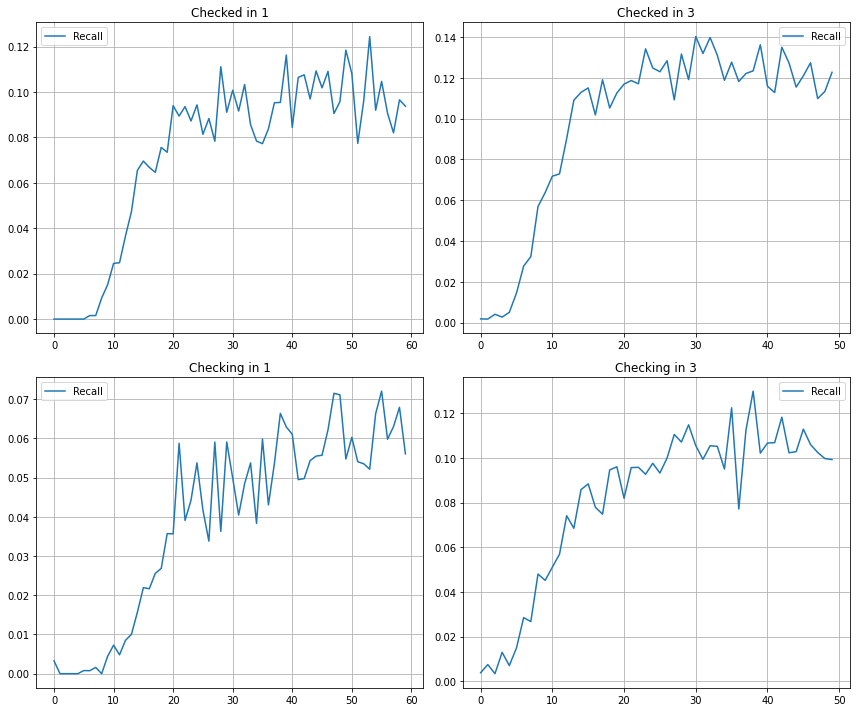

In [ ]:
plt.figure(figsize=(12, 10))
plt.subplot(2, 2, 1)
plt.title('Checked in 1')
plt.plot(logs['checked_in_1_recall'], label='Recall')
plt.legend()
plt.grid()
plt.subplot(2, 2, 2)
plt.title('Checked in 3')
plt.plot(logs['checked_in_3_recall'], label='Recall')
plt.legend()
plt.grid()
plt.subplot(2, 2, 3)
plt.title('Checking in 1')
plt.plot(logs['checking_in_1_recall'], label='Recall')
plt.legend()
plt.grid()
plt.subplot(2, 2, 4)
plt.title('Checking in 3')
plt.plot(logs['checking_in_3_recall'], label='Recall')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

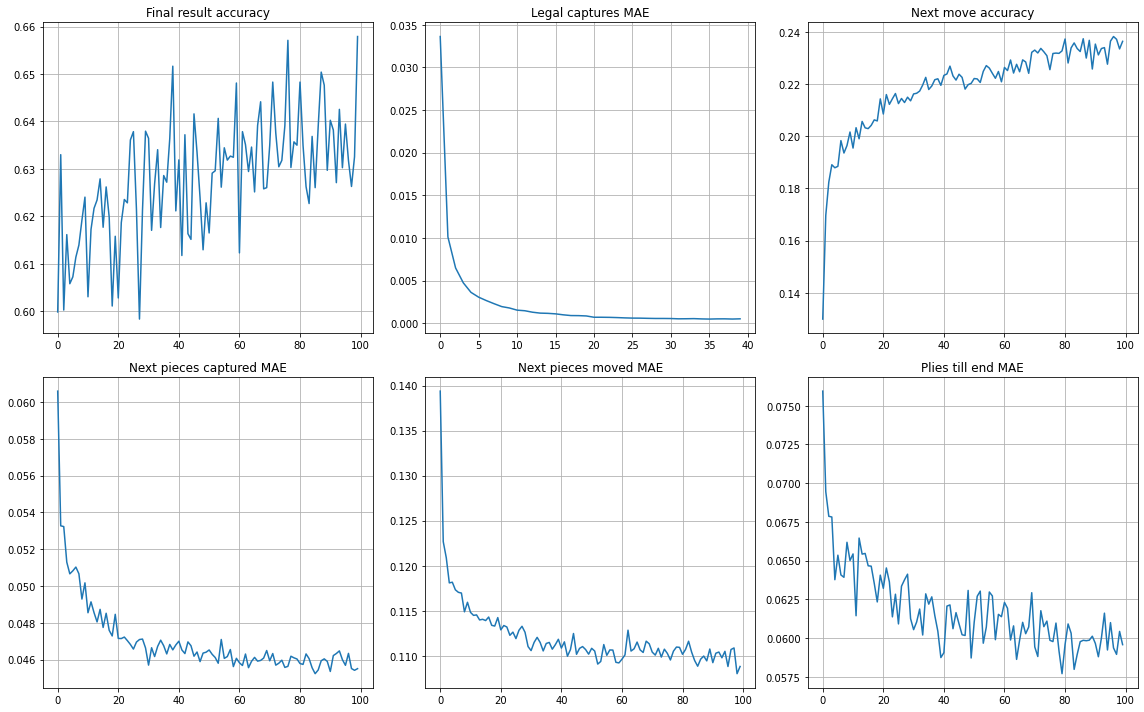

In [ ]:
plt.figure(figsize=(16, 10))
plt.subplot(2, 3, 1)
plt.title('Final result accuracy')
plt.plot(logs['final_result_accuracy'])
plt.grid()
plt.subplot(2, 3, 2)
plt.title('Legal captures MAE')
plt.plot(logs['legal_captures_mae'])
plt.grid()
plt.subplot(2, 3, 3)
plt.title('Next move accuracy')
plt.plot(logs['next_move_accuracy'])
plt.grid()
plt.subplot(2, 3, 4)
plt.title('Next pieces captured MAE')
plt.plot(logs['next_pieces_captured_mae'])
plt.grid()
plt.subplot(2, 3, 5)
plt.title('Next pieces moved MAE')
plt.plot(logs['next_pieces_moved_mae'])
plt.grid()
plt.subplot(2, 3, 6)
plt.title('Plies till end MAE')
plt.plot(logs['plies_till_end_mae'])
plt.grid()
plt.tight_layout()
plt.show()

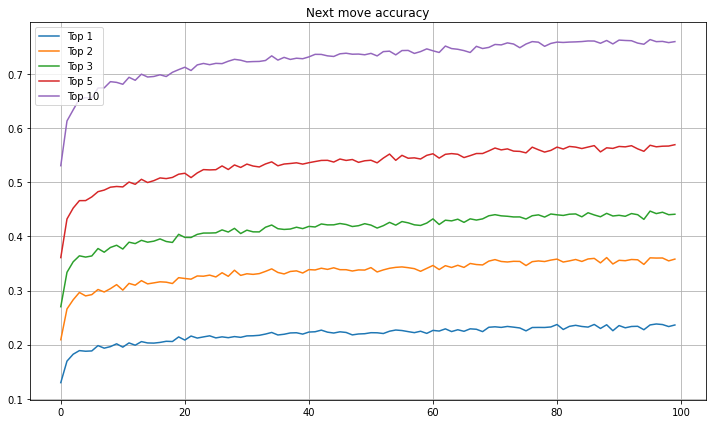

In [ ]:
plt.figure(figsize=(10, 6))
plt.title("Next move accuracy")
plt.plot(logs['next_move_accuracy'], label='Top 1')
plt.plot(logs['next_move_top_2_accuracy'], label='Top 2')
plt.plot(logs['next_move_top_3_accuracy'], label='Top 3')
plt.plot(logs['next_move_top_5_accuracy'], label='Top 5')
plt.plot(logs['next_move_top_10_accuracy'], label='Top 10')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()